In [155]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [156]:
df_master = pd.read_csv("/data/CASP004-01/masterfile.csv")
df_master['product_brand'] = df_master['product_brand'].str.rstrip()
def correct_product_brand_spacing(df, column_name):
    # Add a space before the slash if it's not there and remove extra spaces after the slash
    df[column_name] = df[column_name].str.replace(r'/', ' / ').str.replace(r'\s+', ' ', regex=True)
    return df

df_master = correct_product_brand_spacing(df_master, 'product_brand')

## Outlier Analysis

In [157]:
df_non_outlier = df_master[df_master['outlier_alert']==False]
len(df_non_outlier)

912

In [158]:
df_outlier = df_master[df_master['outlier_alert']==True]
len(df_outlier)

132

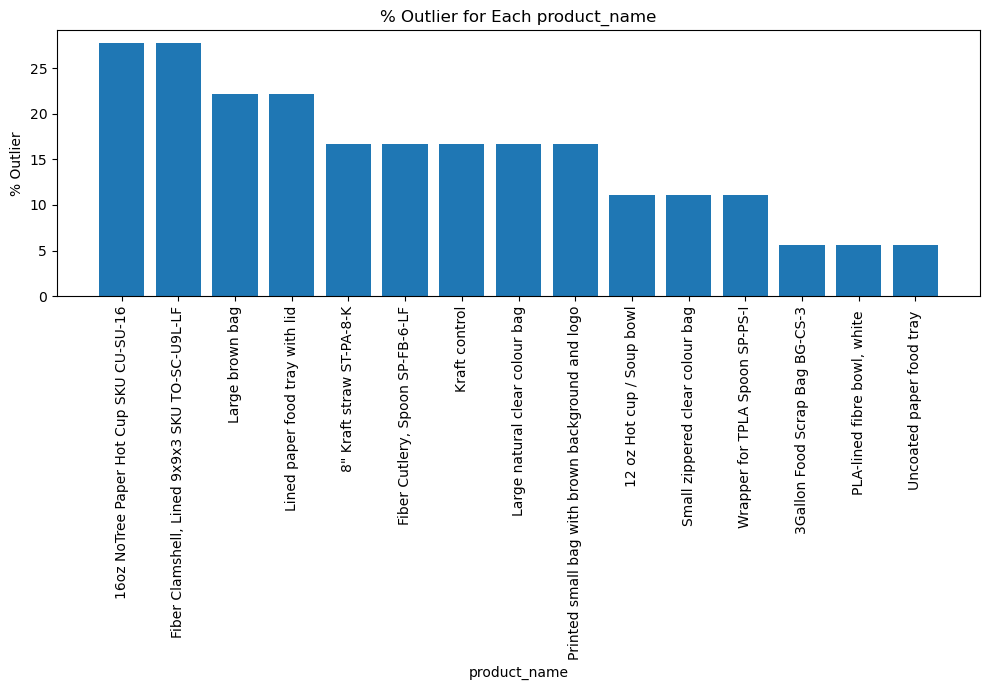

In [159]:
def outlier_plot(col):
    outlier_category = df_outlier.groupby([col])['outlier_alert'].count().reset_index()
    df = df_master.groupby([col])['outlier_alert'].count().reset_index()
    outlier_category = outlier_category.merge(df, on=col)
    outlier_category['%_outlier'] = (outlier_category['outlier_alert_x'] / outlier_category['outlier_alert_y'] * 100).round(2)
    outlier_category = outlier_category.sort_values(by='%_outlier', ascending=False)
    plt.figure(figsize=(10, 7))
    plt.bar(outlier_category[col], outlier_category['%_outlier'])
    plt.title(f'% Outlier for Each {col}')
    plt.xlabel(col)
    plt.ylabel('% Outlier')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
outlier_plot('product_name')


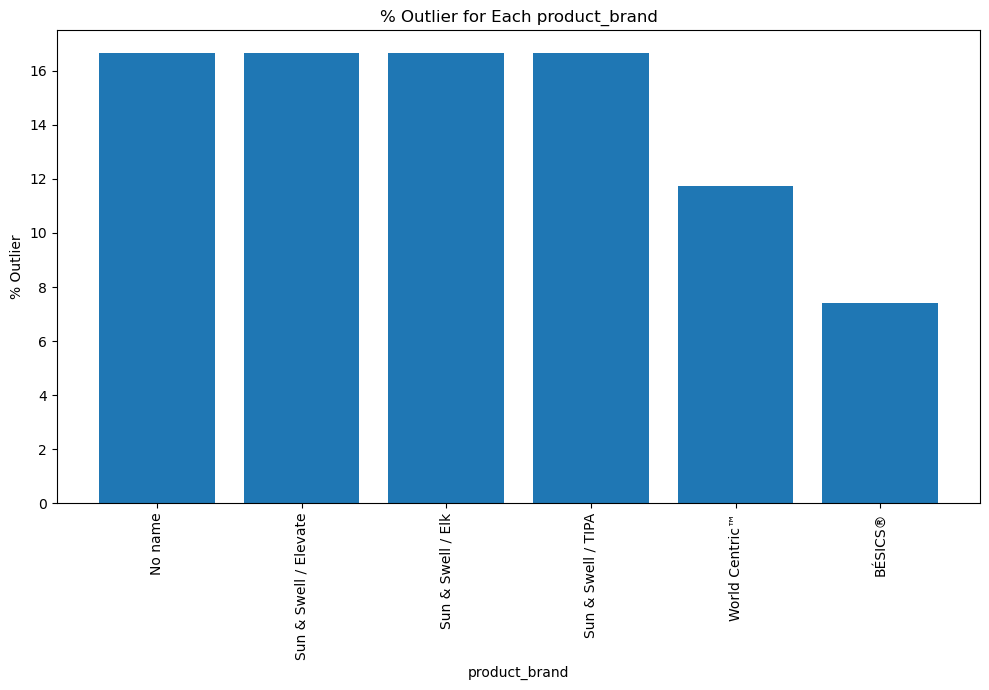

In [160]:
outlier_plot('product_brand')

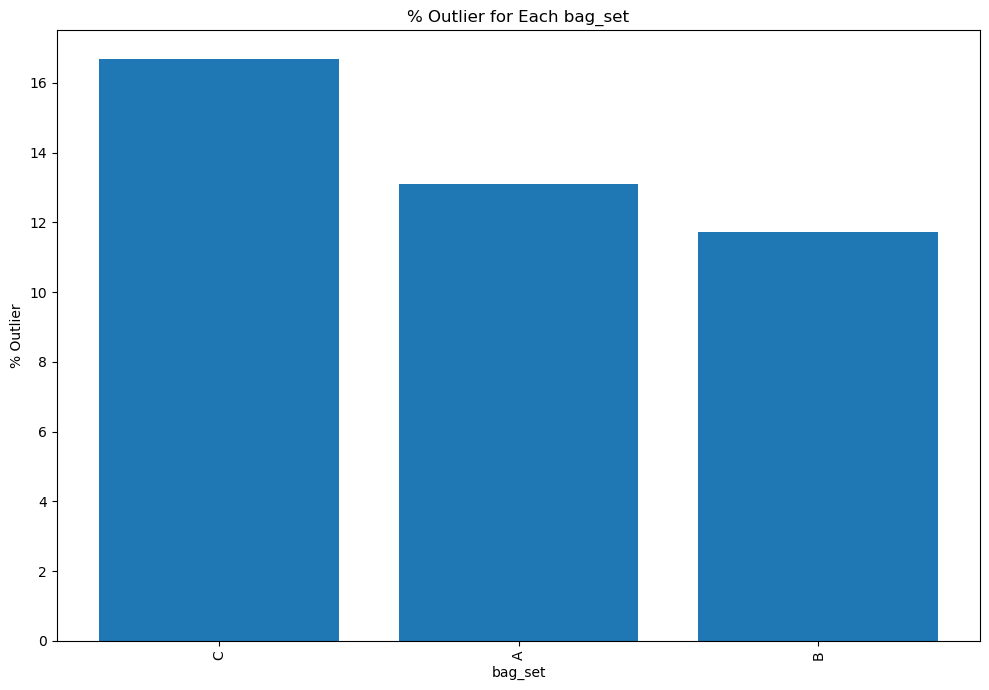

In [161]:
outlier_plot('bag_set')

### Plot Functions Set Up

In [180]:
df_end = df_master[df_master['trial_stage'] == 'End']

def bar_whisker_plot(df, x, y, outlier):
    grouped_data = df.groupby(x)[y].agg(['mean', 'std']).sort_values(by='mean', ascending=False)
    
    plt.figure(figsize=(10, 7))
    plt.bar(grouped_data.index, grouped_data['mean'], yerr=grouped_data['std'], capsize=5)
    plt.title(f'Mean {y} for Each {x} with Error Bars {outlier}')
    plt.xlabel(x)
    plt.ylabel(f'Mean {y}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_with_outliers(df_end, x, y):
    bar_whisker_plot(df_end, x, y, 'for All Data')
    bar_whisker_plot(df_end[df_end['outlier_alert']==False], x, y, 'Without Outliers')
    bar_whisker_plot(df_end[df_end['outlier_alert']==True], x, y, 'for Outliers Only')

def bar_whisker_combined_plot_horizontal(df, x, y):
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))

    # Define the datasets for the three conditions
    datasets = {
        'All Data': df,
        'Without Outliers': df[df['outlier_alert'] == False],
        'With Outliers Only': df[df['outlier_alert'] == True]
    }
    
    for i, (title, df) in enumerate(datasets.items()):
        grouped_data = df.groupby(x)[y].agg(['mean', 'std']).sort_values(by='mean', ascending=False)
        axes[i].bar(grouped_data.index, grouped_data['mean'], yerr=grouped_data['std'], capsize=5)
        axes[i].set_title(f'Mean {y} for Each {x} {title}')
        axes[i].set_xlabel(x)
        axes[i].set_ylabel(y)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')

    plt.tight_layout()

    plt.show()

df_non_outlier = df_end[df_end['outlier_alert']==False]

def plot_violin(df, x, y):
    plt.figure(figsize=(8, 5))
    sns.violinplot(x=x, y=y, data=df, palette="viridis")
    plt.title('Violin Plot of % Residual for Each {x} Type')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()




## Average Weight Pre and Post Composting

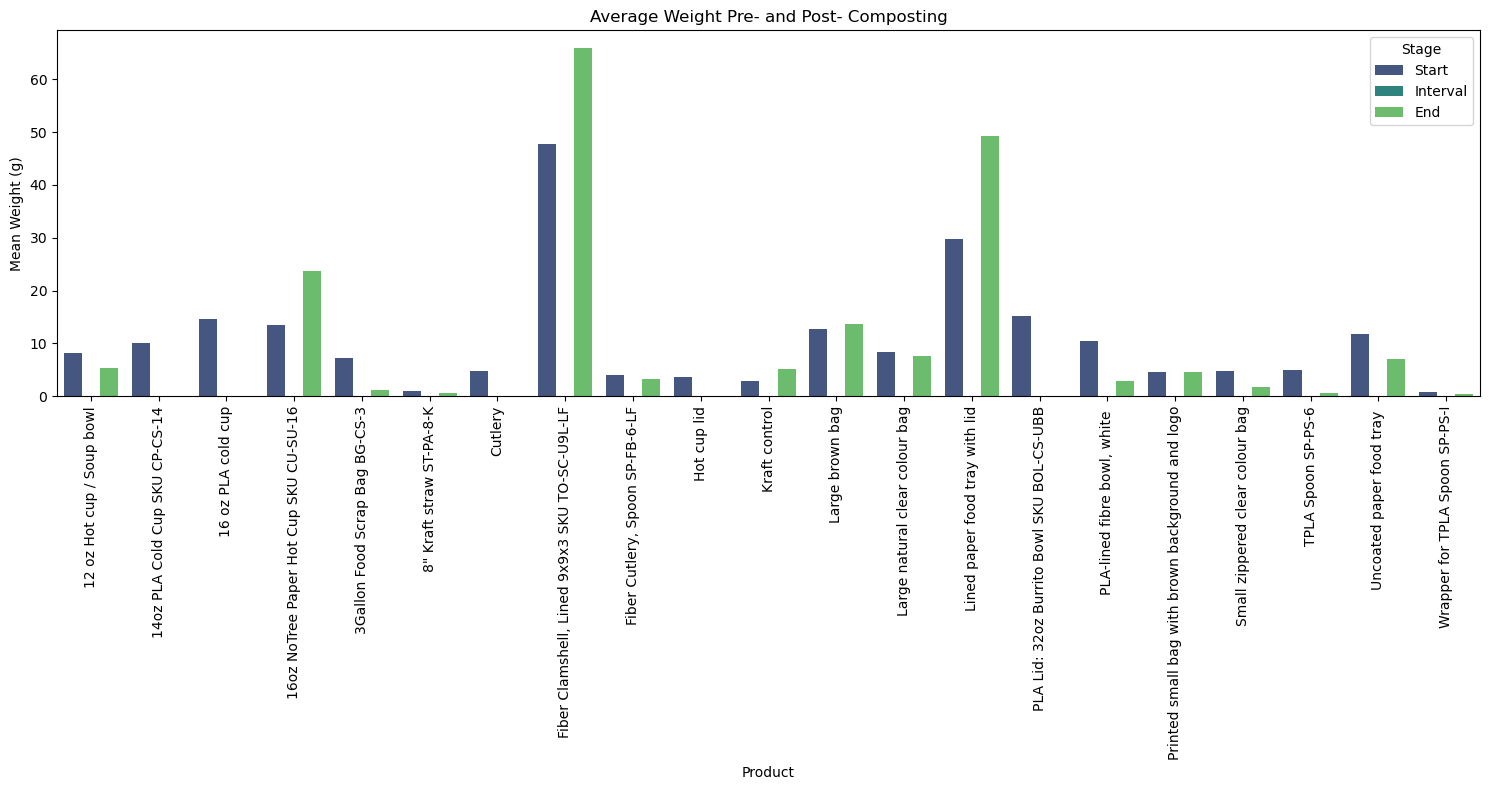

In [163]:
stage_order = pd.CategoricalDtype(
    categories=["Start", "Interval", "End"],
    ordered=True
)
df_master['trial_stage'] = df_master['trial_stage'].astype(stage_order)

stages_ordered = df_master.groupby(['product_name', 'trial_stage'])['mean_weight_final_g'].mean().reset_index().round(2)
plt.figure(figsize=(15, 8))
sns.barplot(x='product_name', y='mean_weight_final_g', hue='trial_stage', data=stages_ordered, palette="viridis")
plt.title('Average Weight Pre- and Post- Composting')
plt.xlabel('Product')
plt.ylabel('Mean Weight (g)')
plt.xticks(rotation=90)
plt.legend(title='Stage')
plt.tight_layout()
plt.show()


## % Decomposed by Products

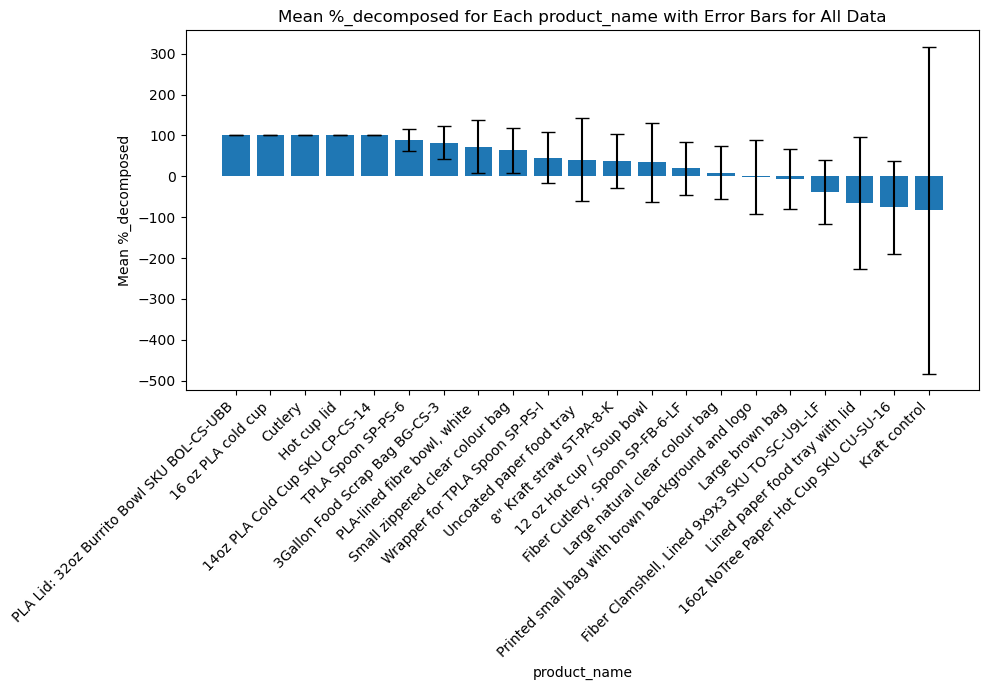

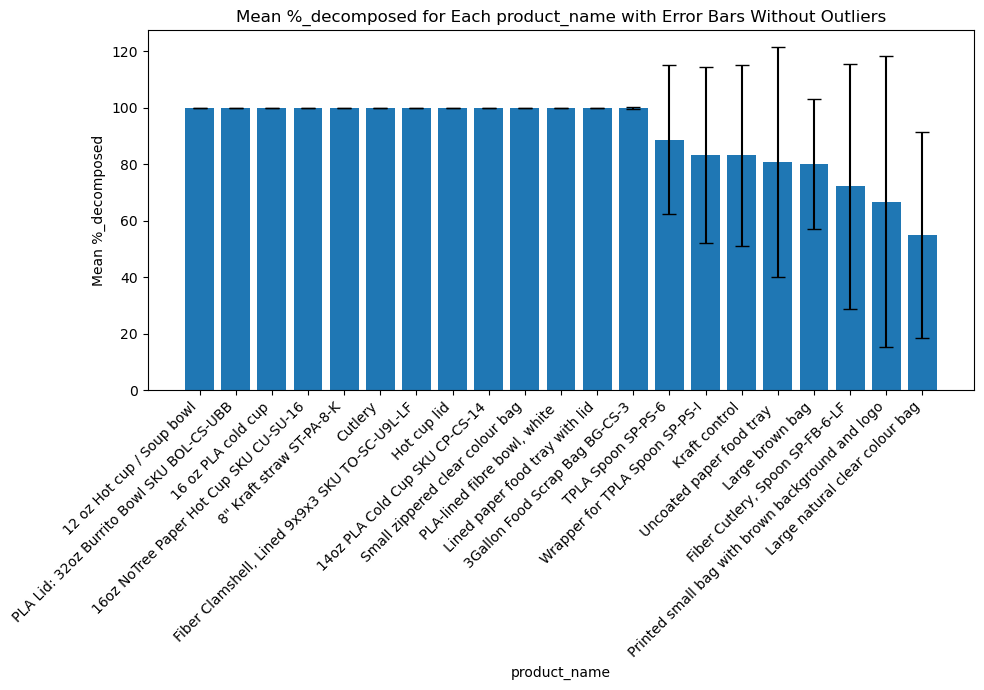

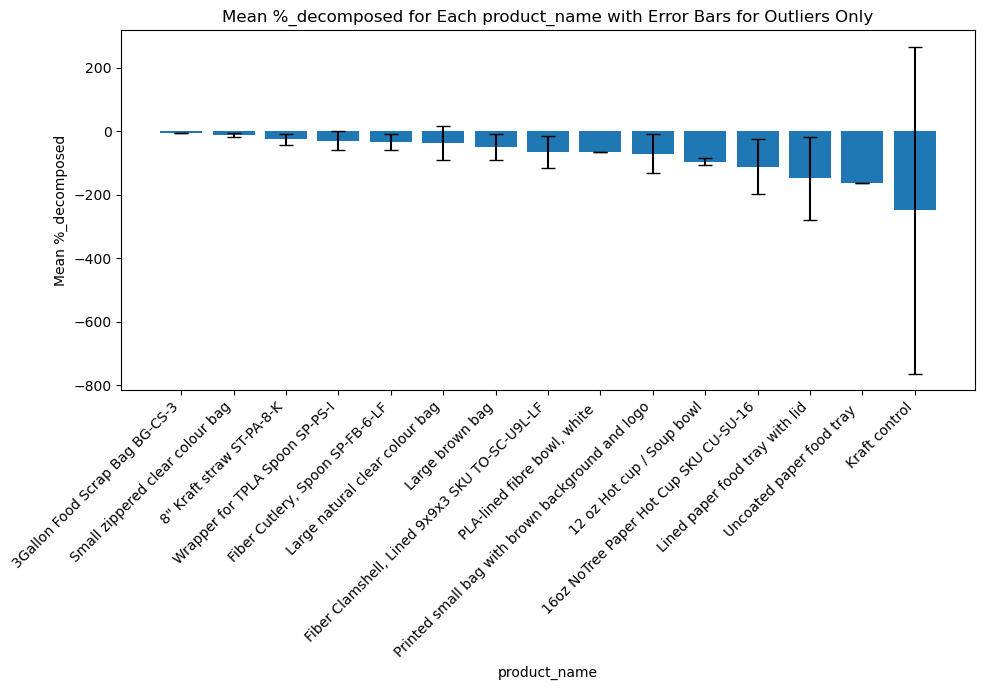

In [164]:
plot_with_outliers(df_end, 'product_name', '%_decomposed')

## % Residual by Products

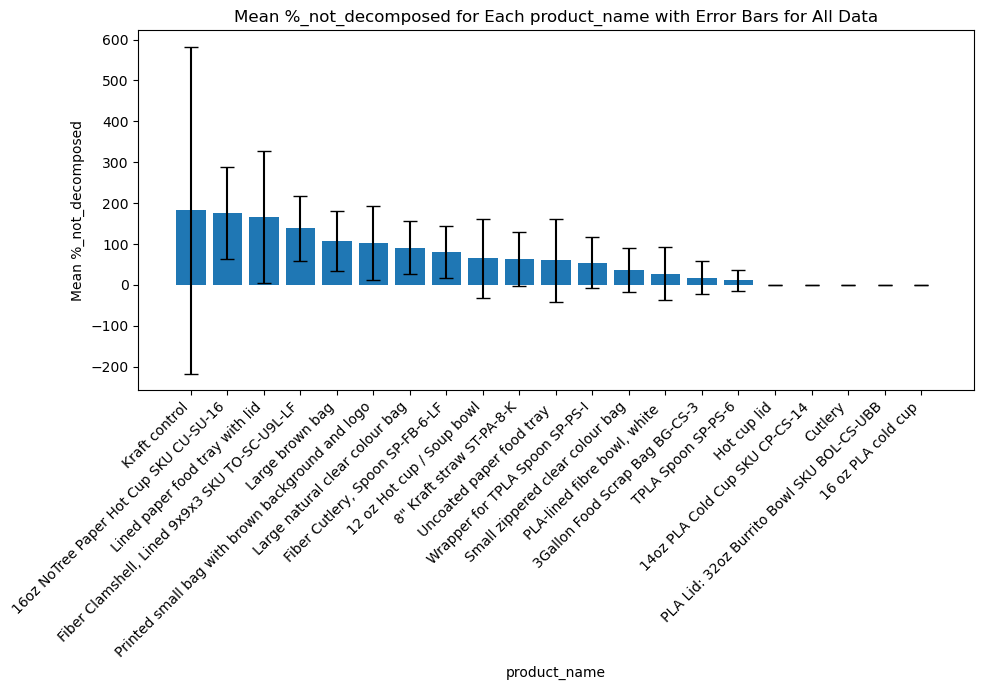

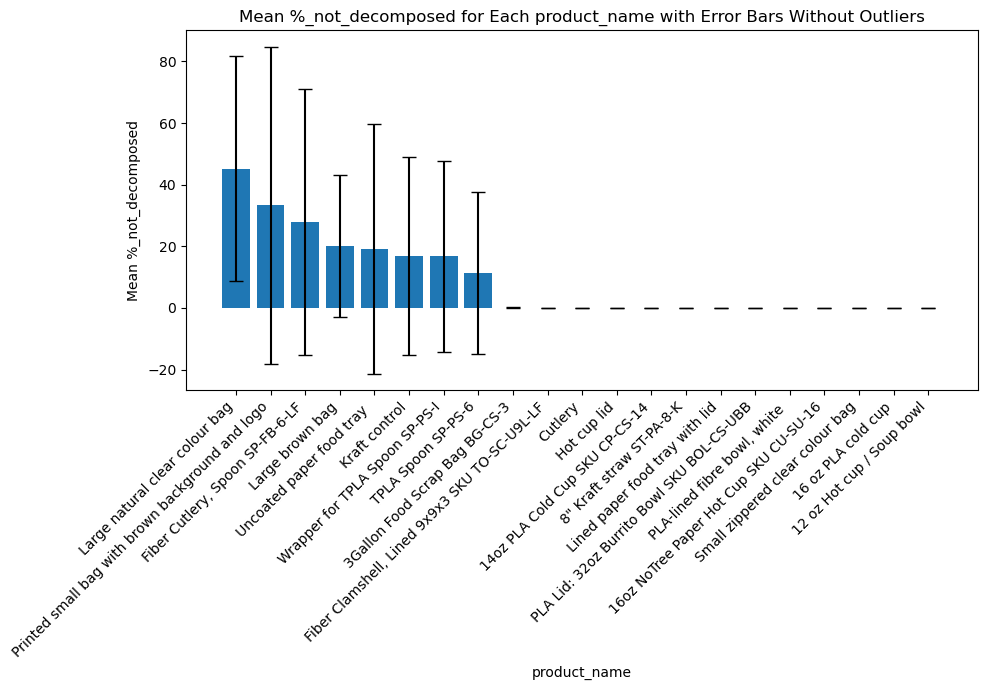

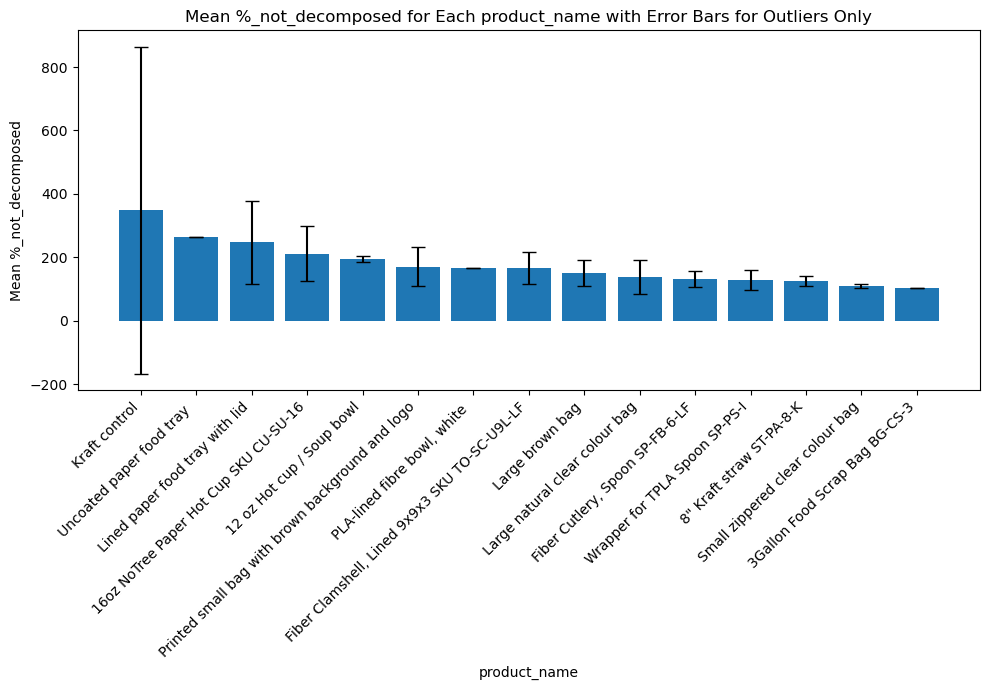

In [165]:
plot_with_outliers(df_end, 'product_name', '%_not_decomposed')

## % Residual by Material Class I


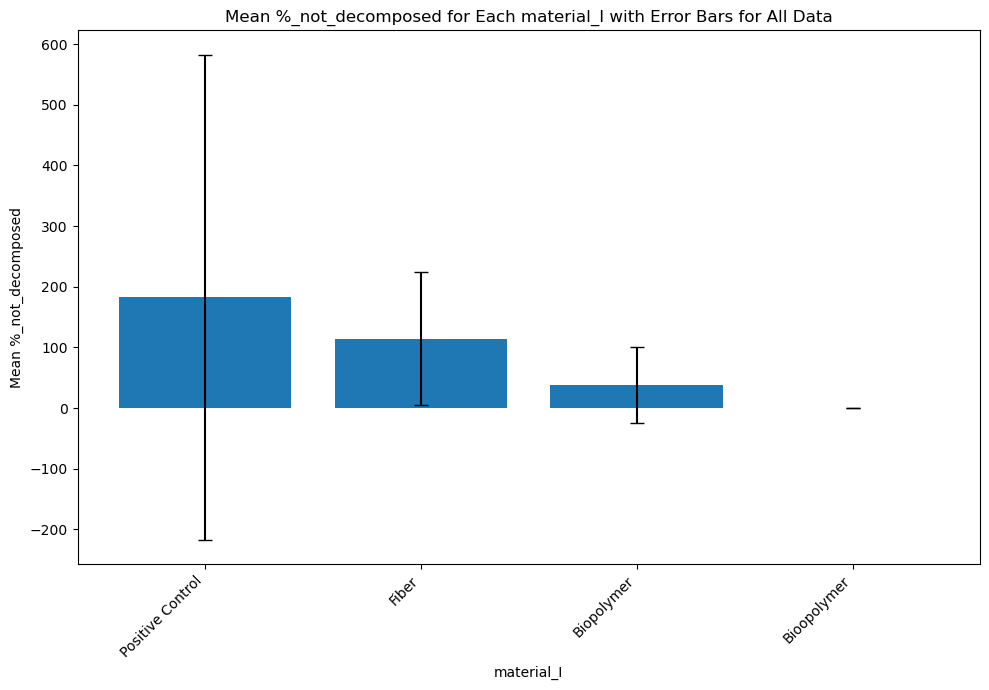

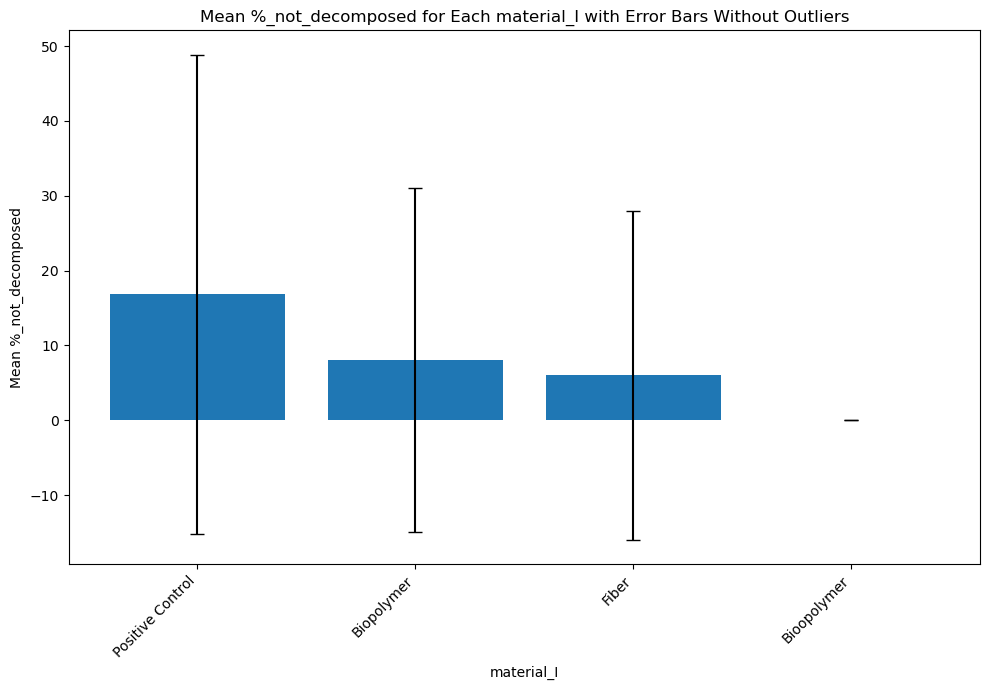

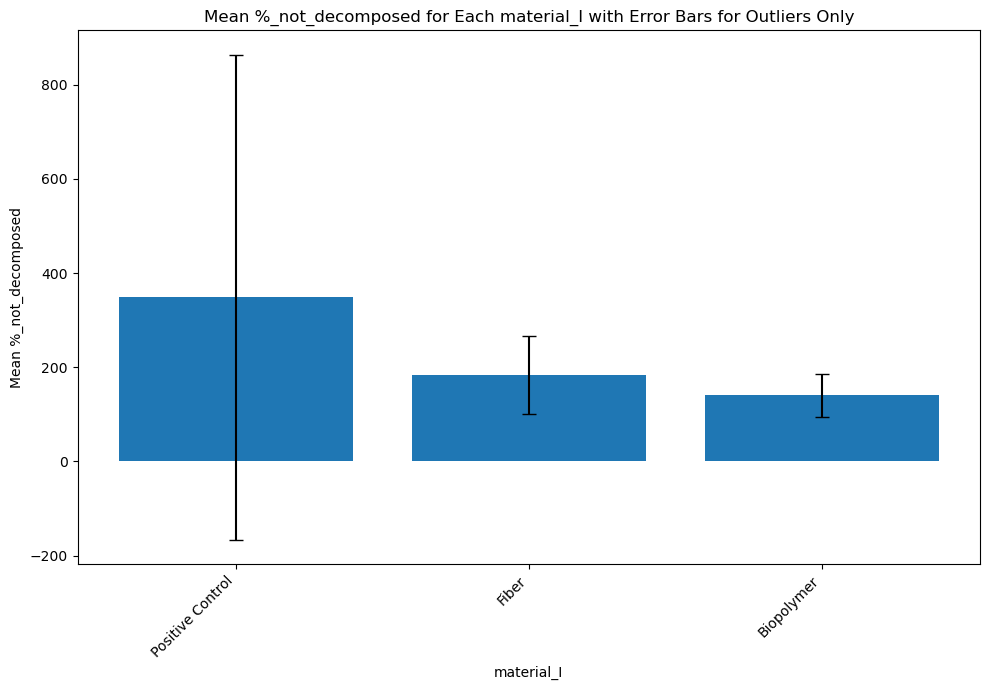

In [166]:
plot_with_outliers(df_end, 'material_I', '%_not_decomposed')


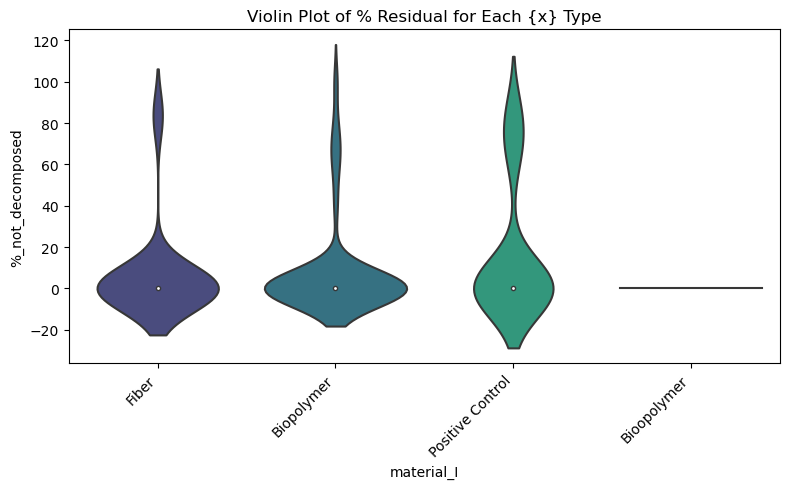

In [181]:
plot_violin(df_non_outlier, 'material_I', '%_not_decomposed')

## % Residual by Material Class II


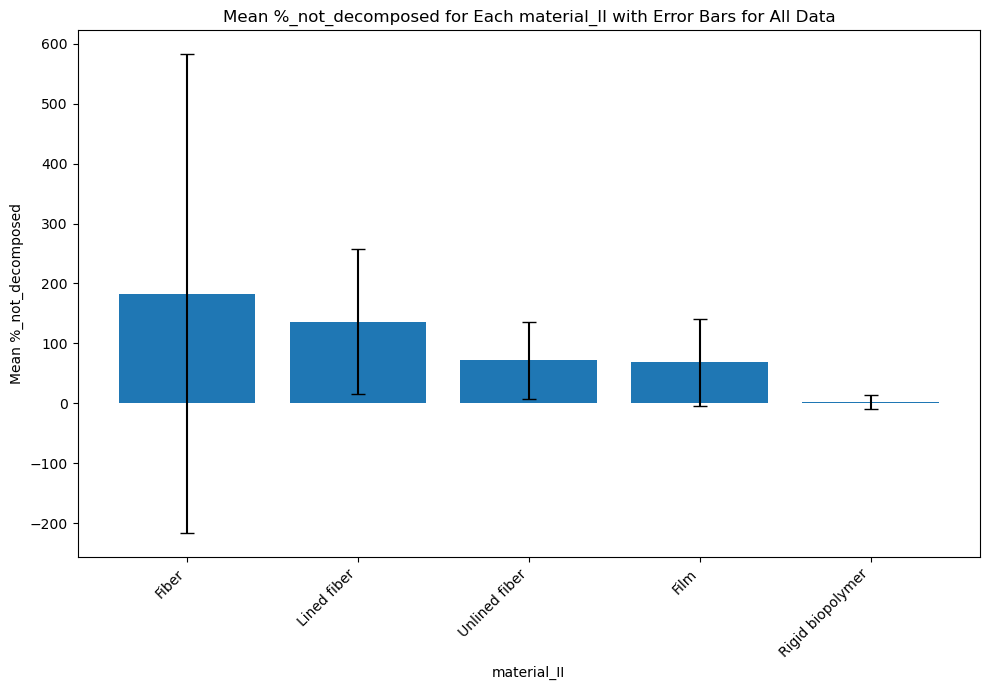

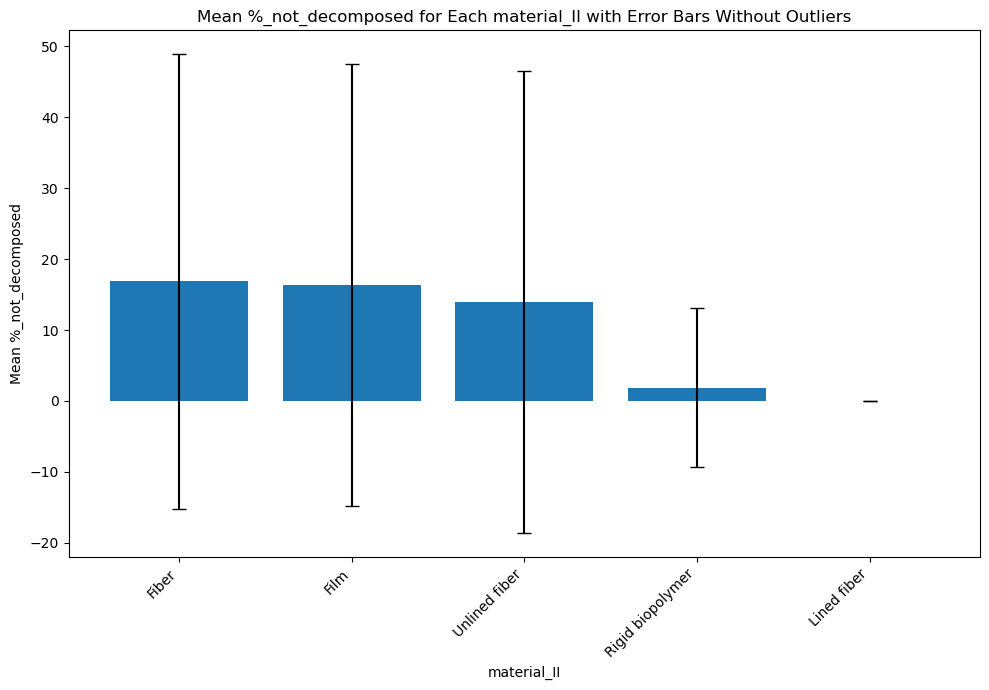

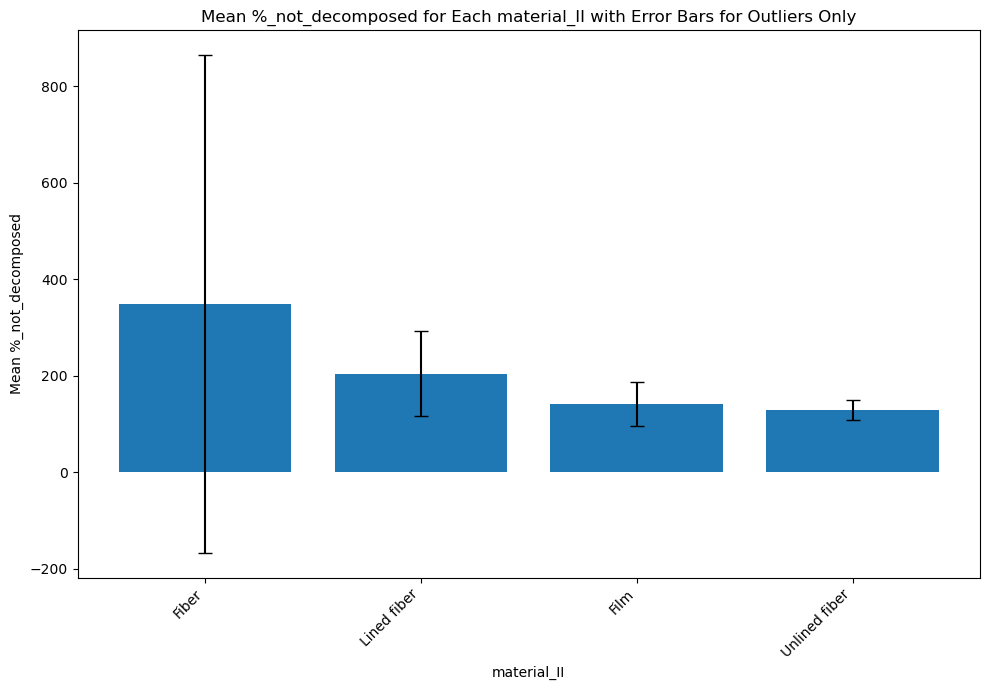

In [168]:
plot_with_outliers(df_end, 'material_II', '%_not_decomposed')

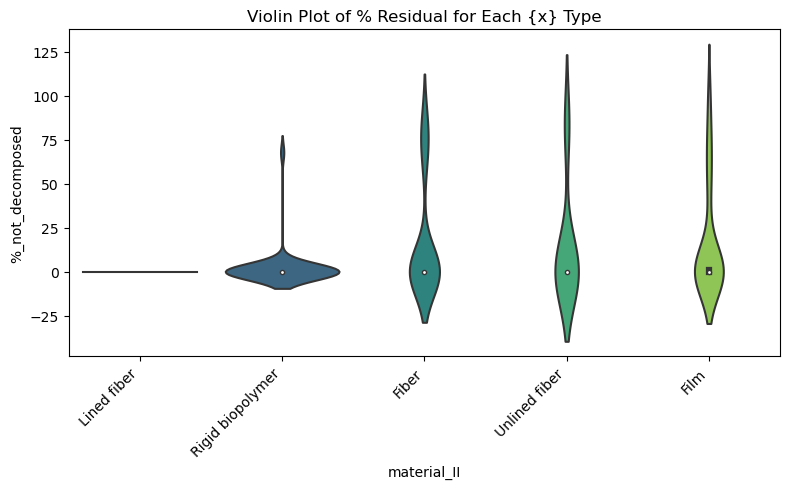

In [182]:
plot_violin(df_non_outlier, 'material_II', '%_not_decomposed')

## % Residual by Material Class III

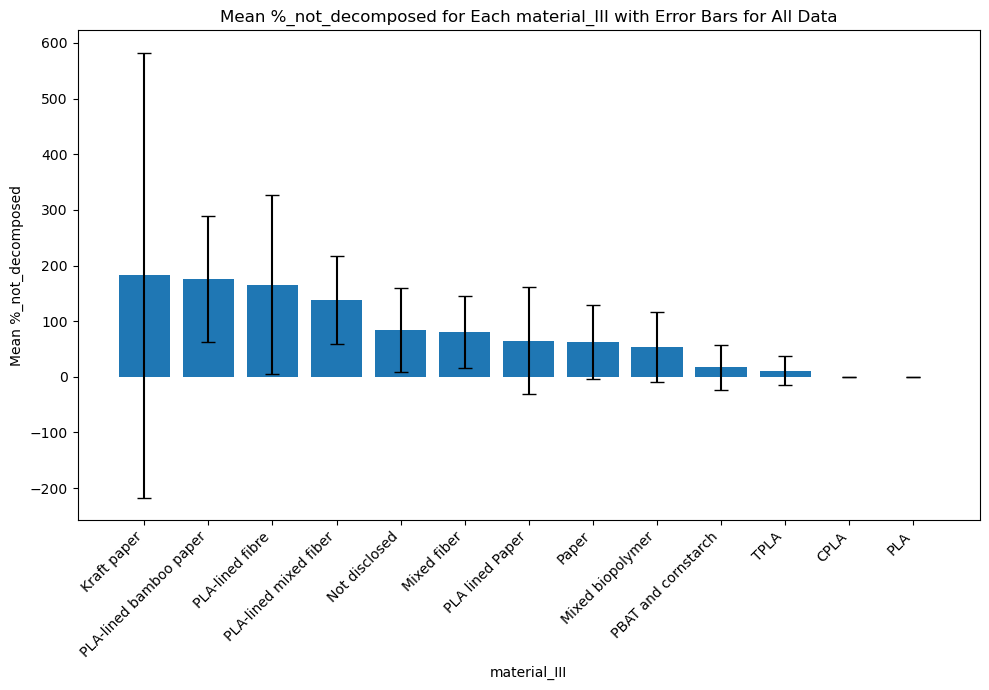

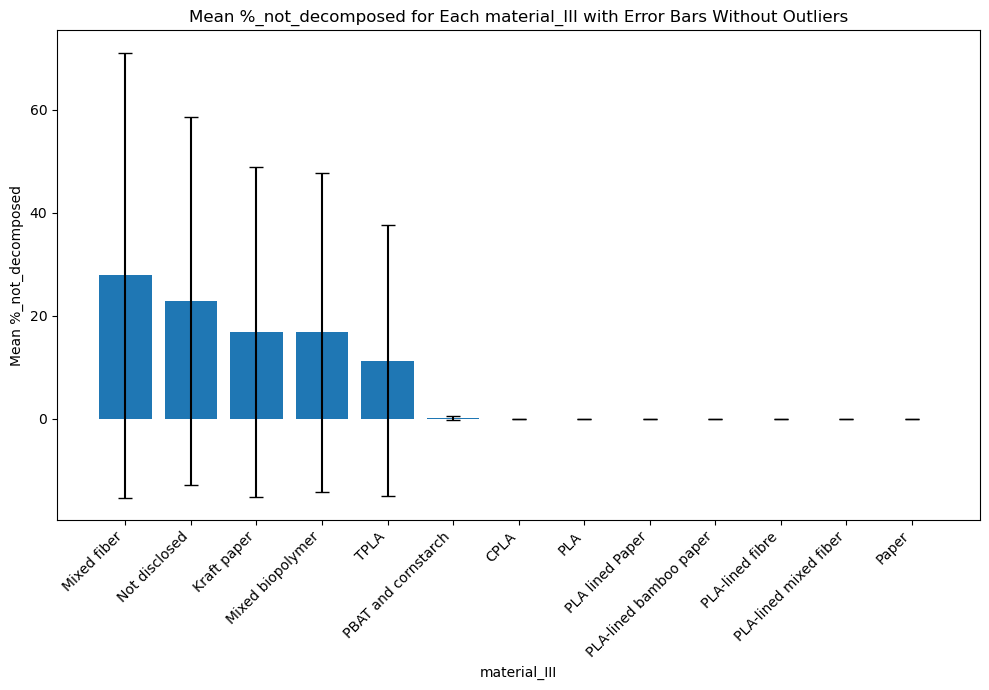

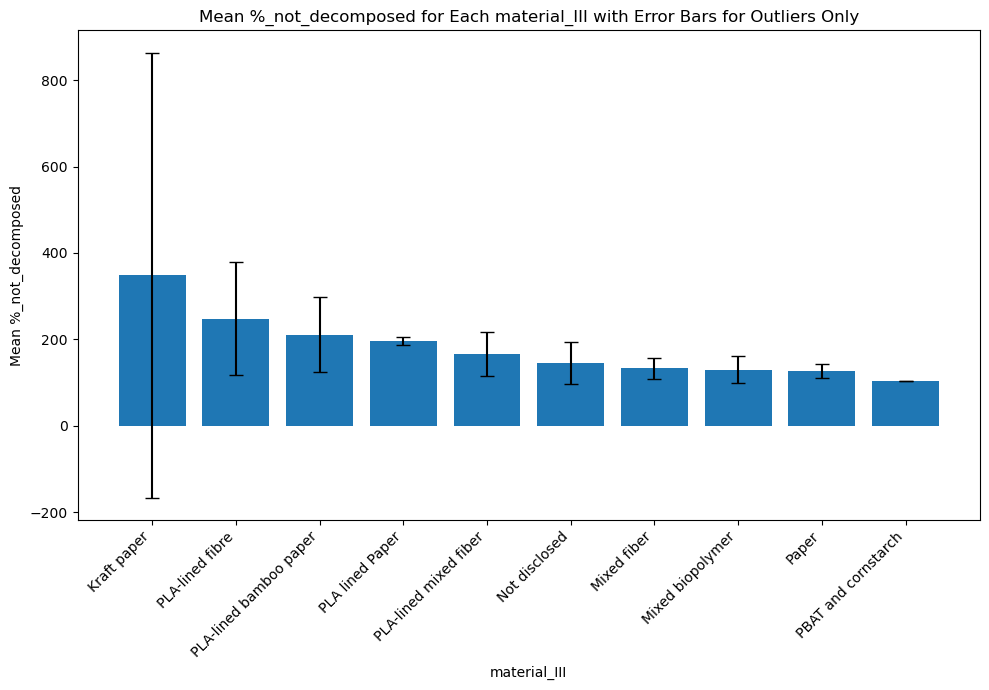

In [170]:
plot_with_outliers(df_end, 'material_III', '%_not_decomposed')

## % Residual by Product Brand

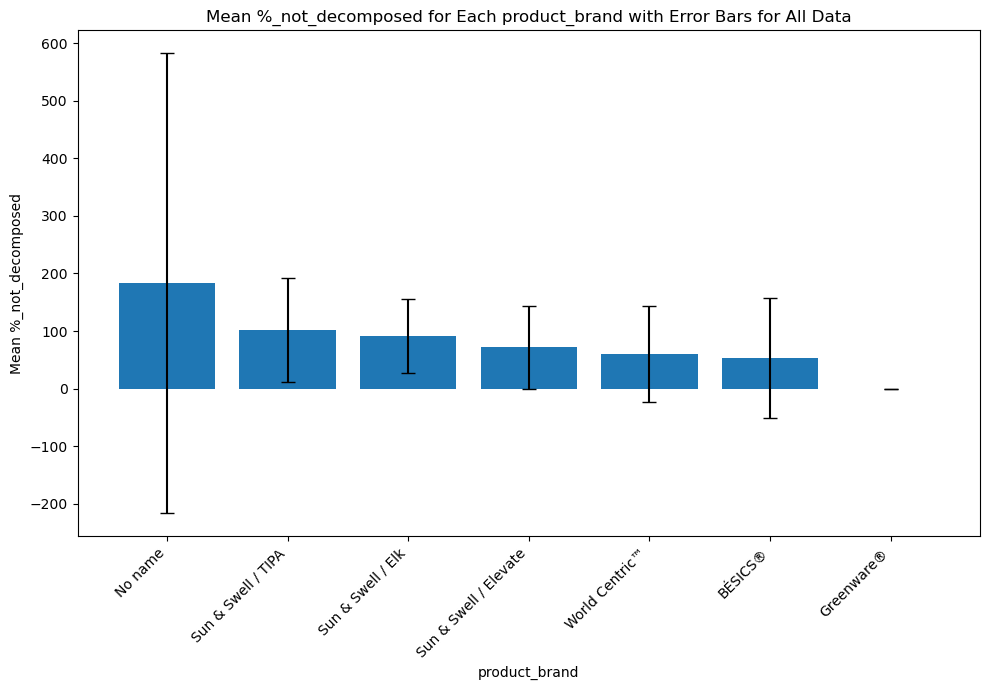

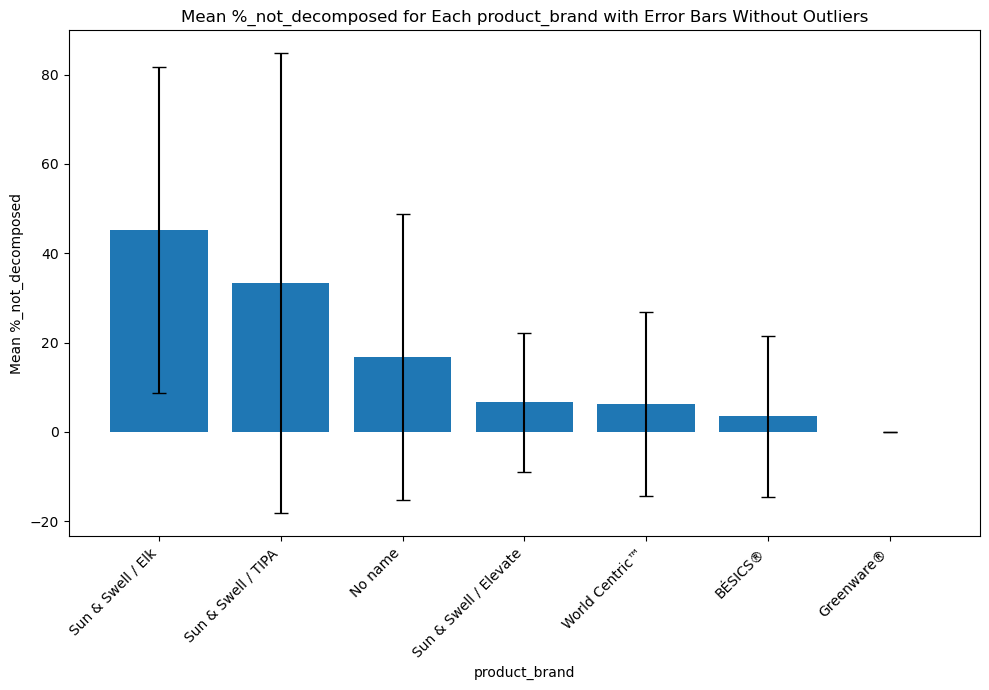

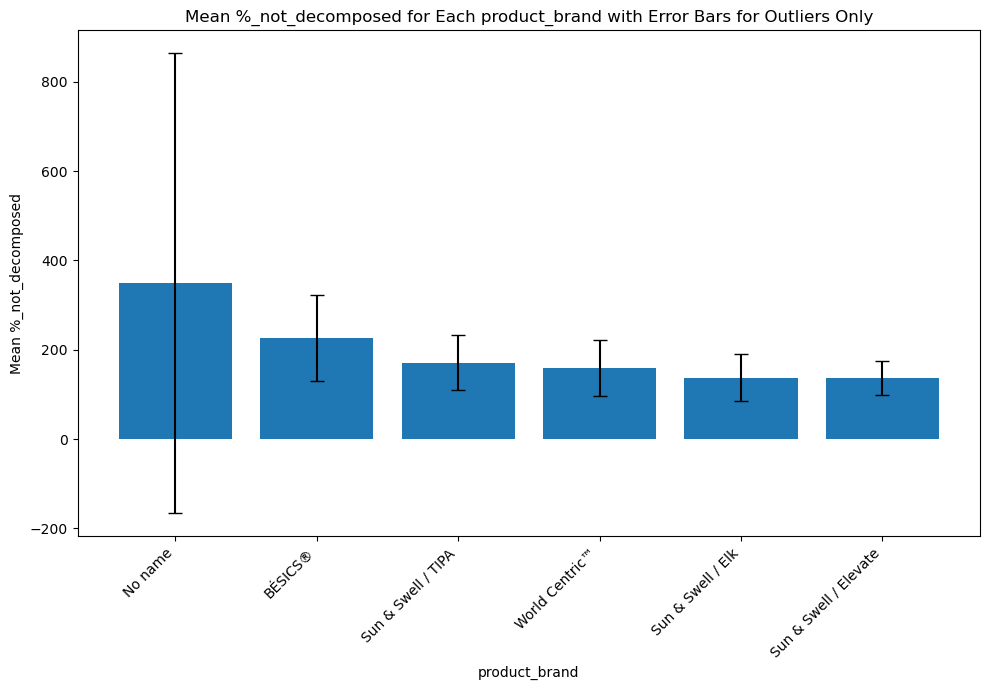

In [171]:
plot_with_outliers(df_end, 'product_brand', '%_not_decomposed')

## % Residual by Bag Placement (Top vs. Bottom)

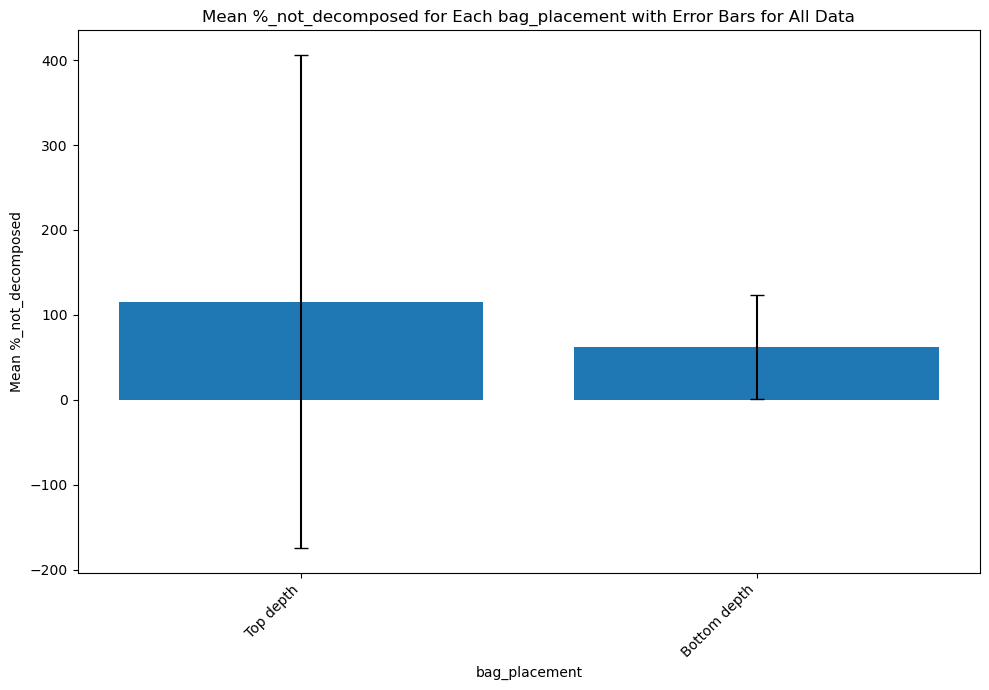

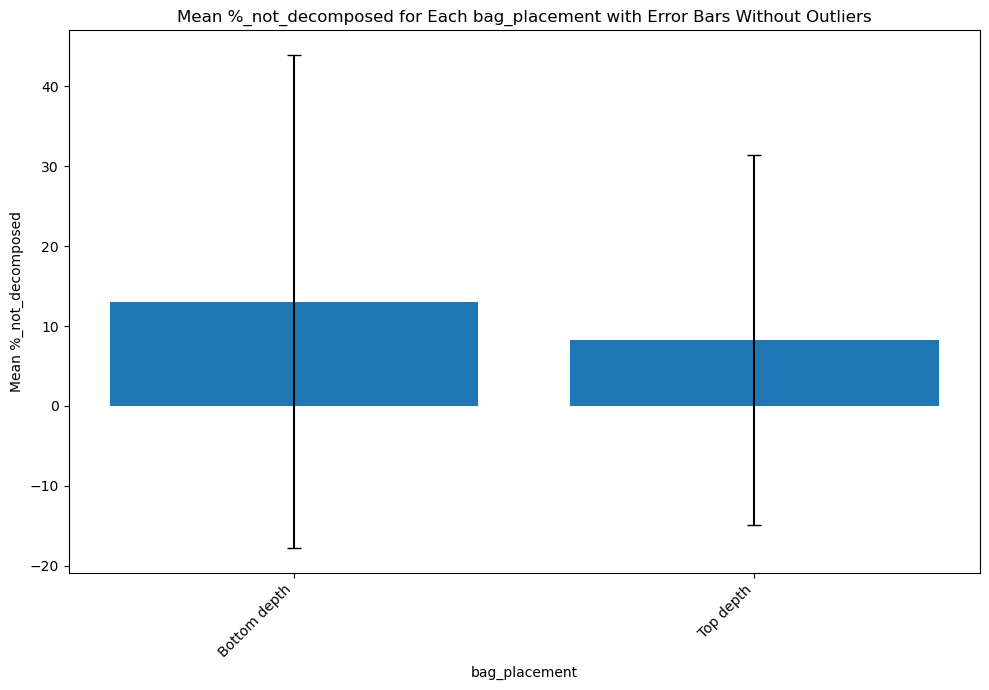

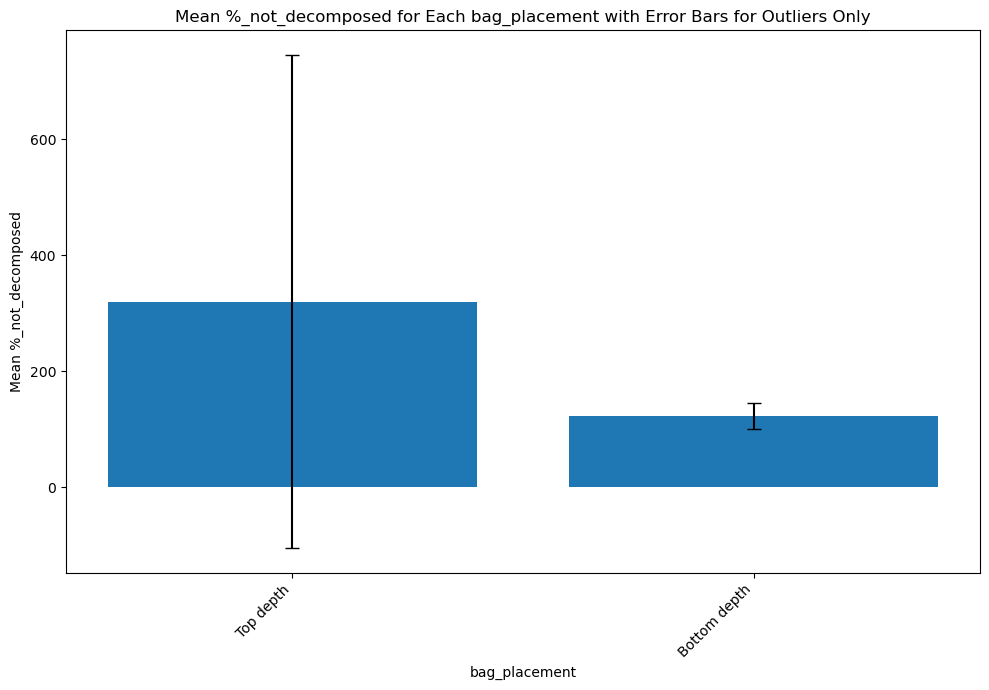

In [172]:
plot_with_outliers(df_end, 'bag_placement', '%_not_decomposed')


## Combines Plots for Use in Presentation Slides

/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')
/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')
/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')


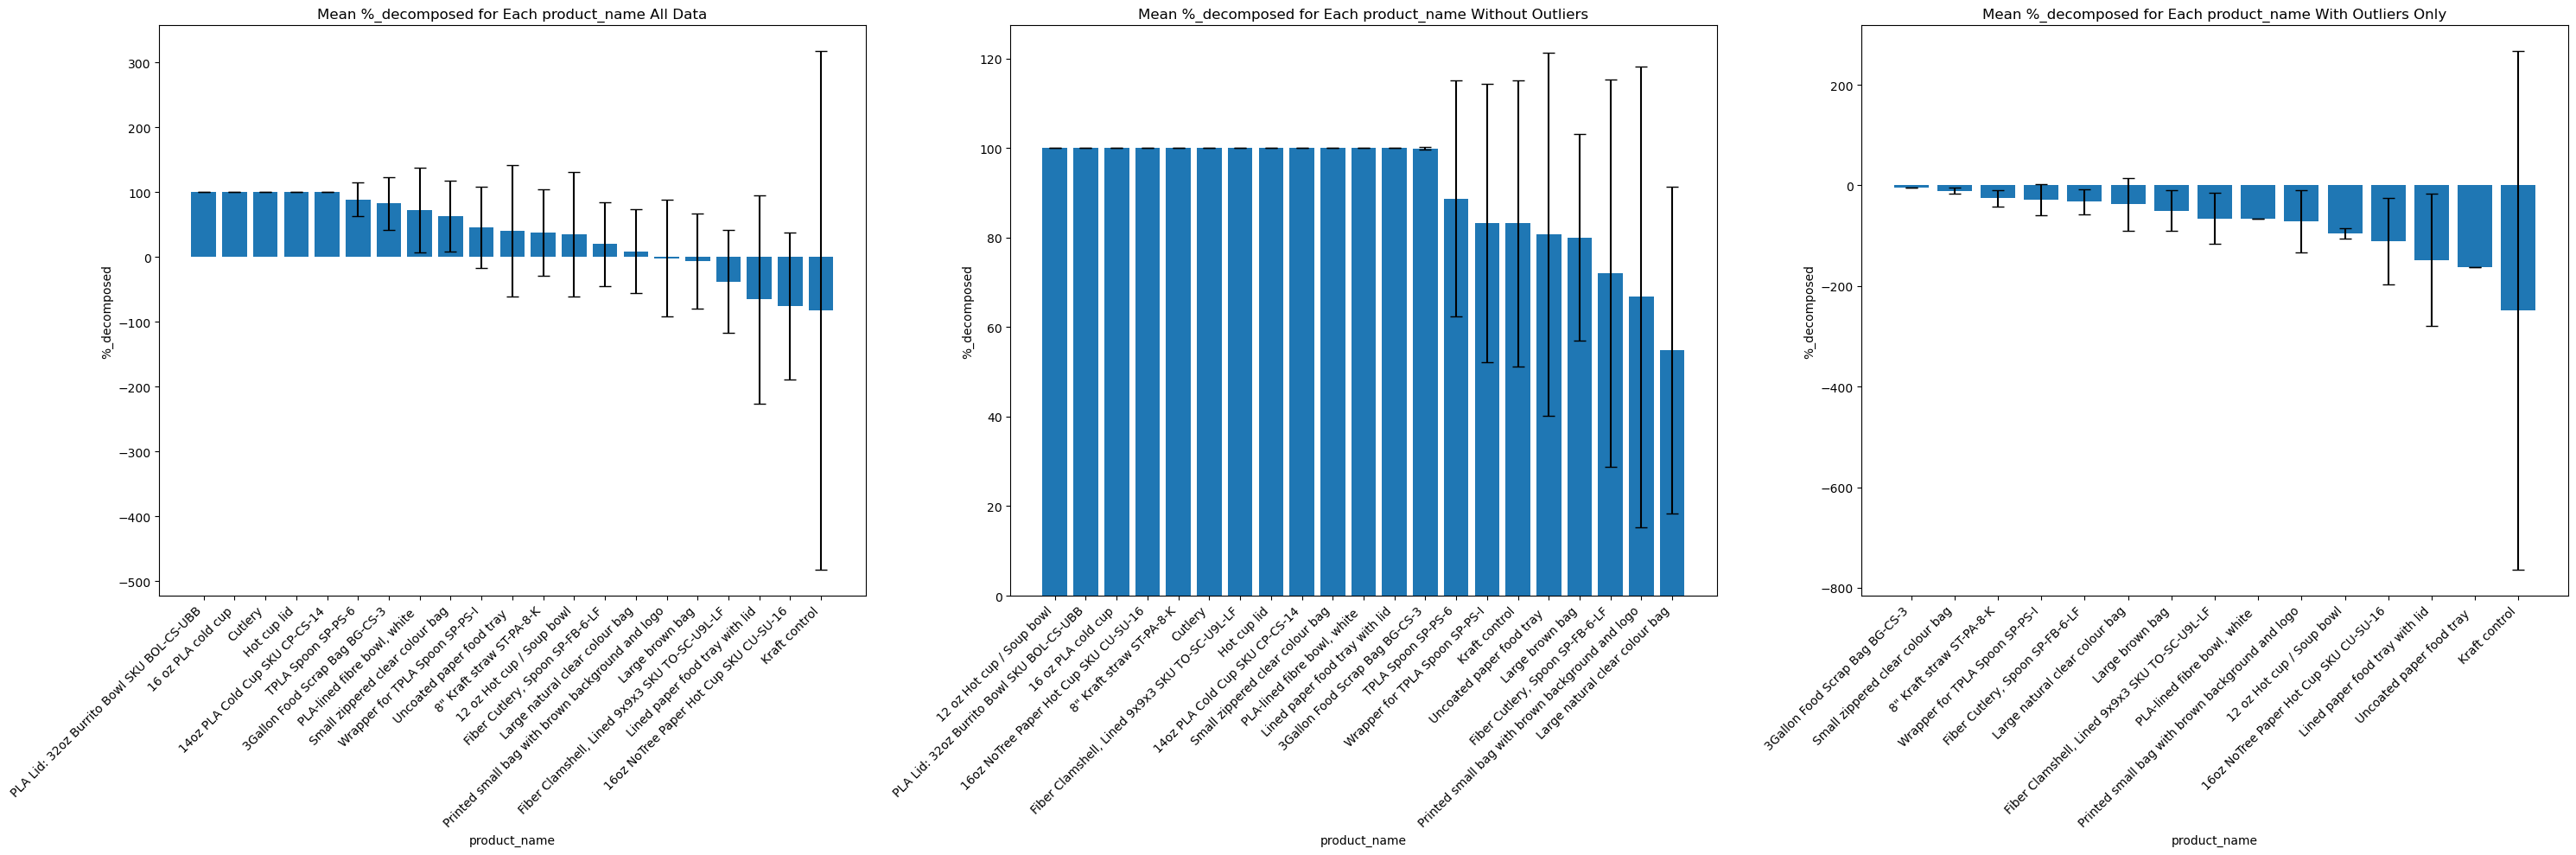

In [173]:
bar_whisker_combined_plot_horizontal(df_end, 'product_name', '%_decomposed')


/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')
/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')
/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')


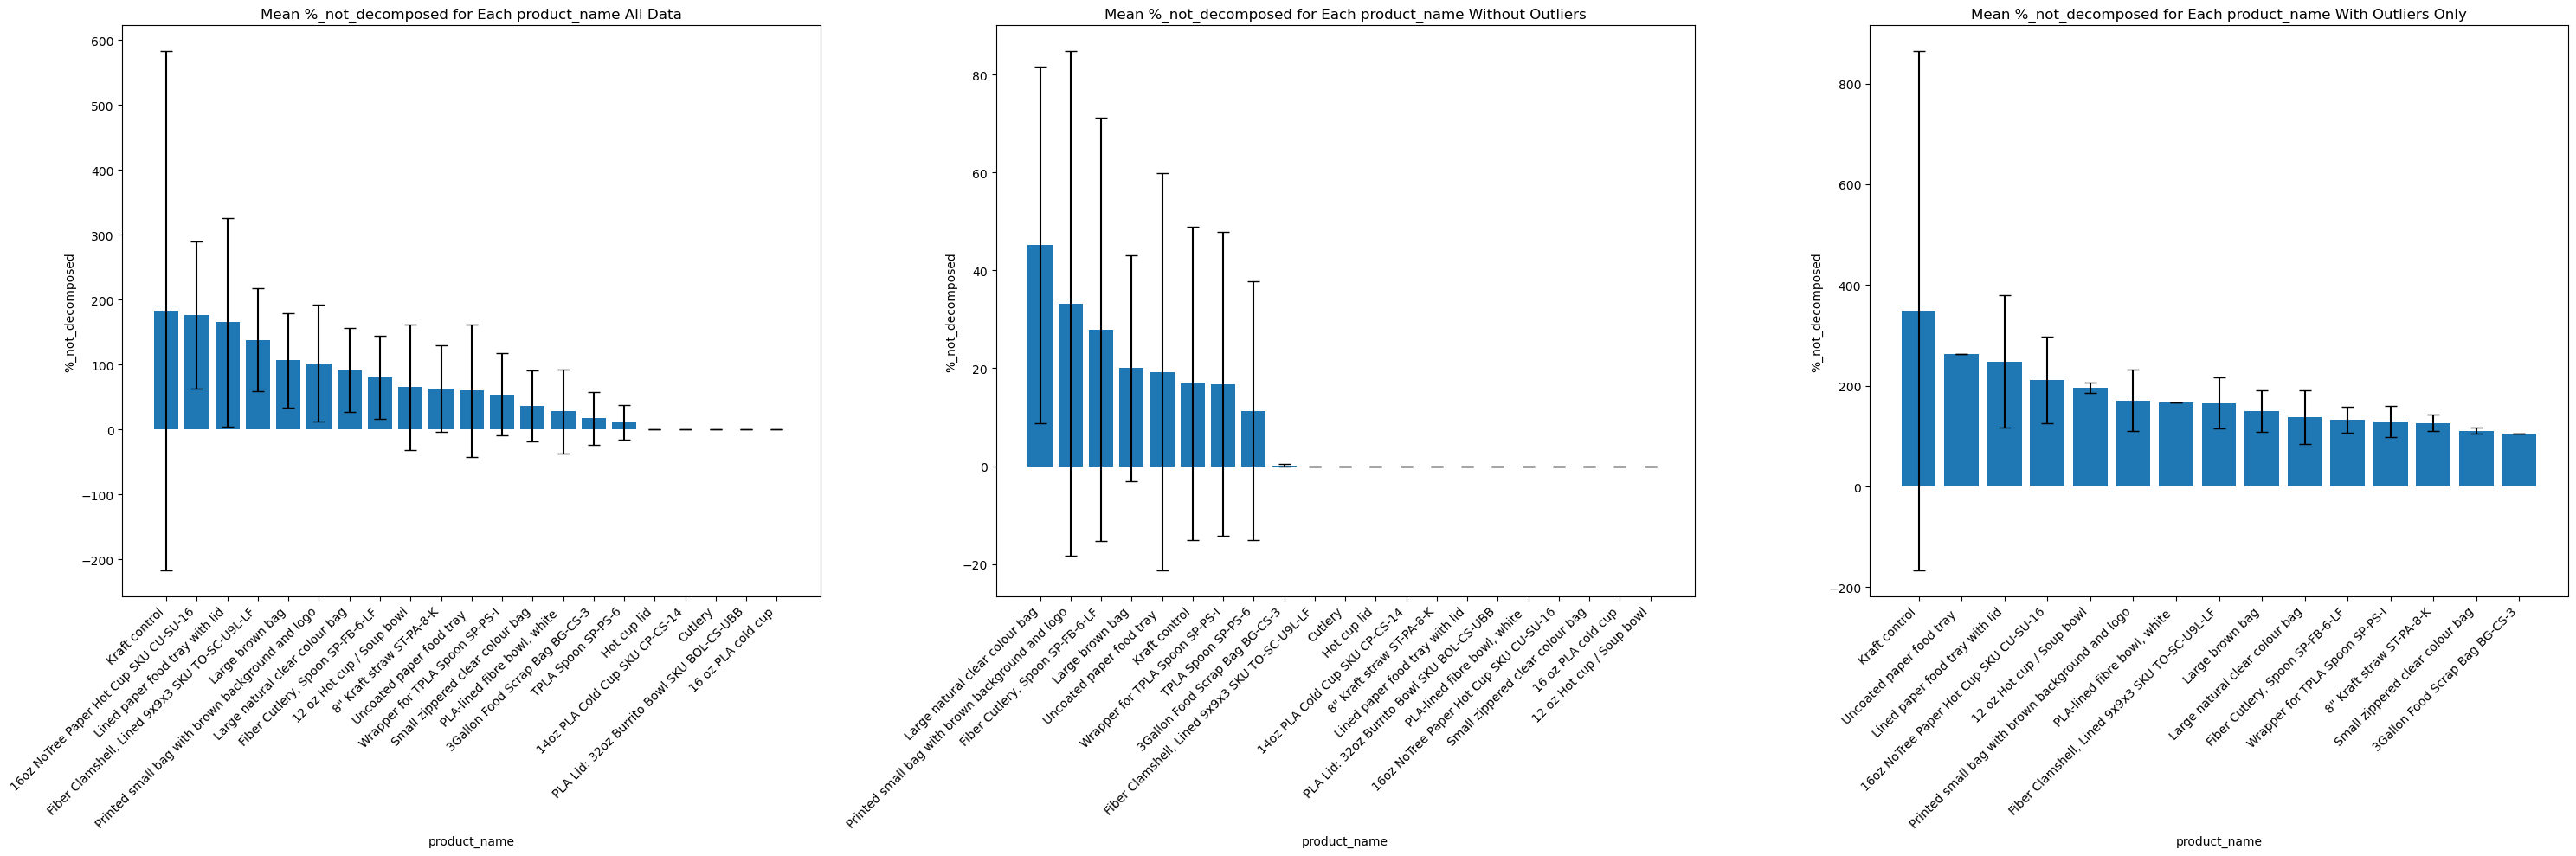

In [174]:
bar_whisker_combined_plot_horizontal(df_end, 'product_name', '%_not_decomposed')


/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')
/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')
/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')


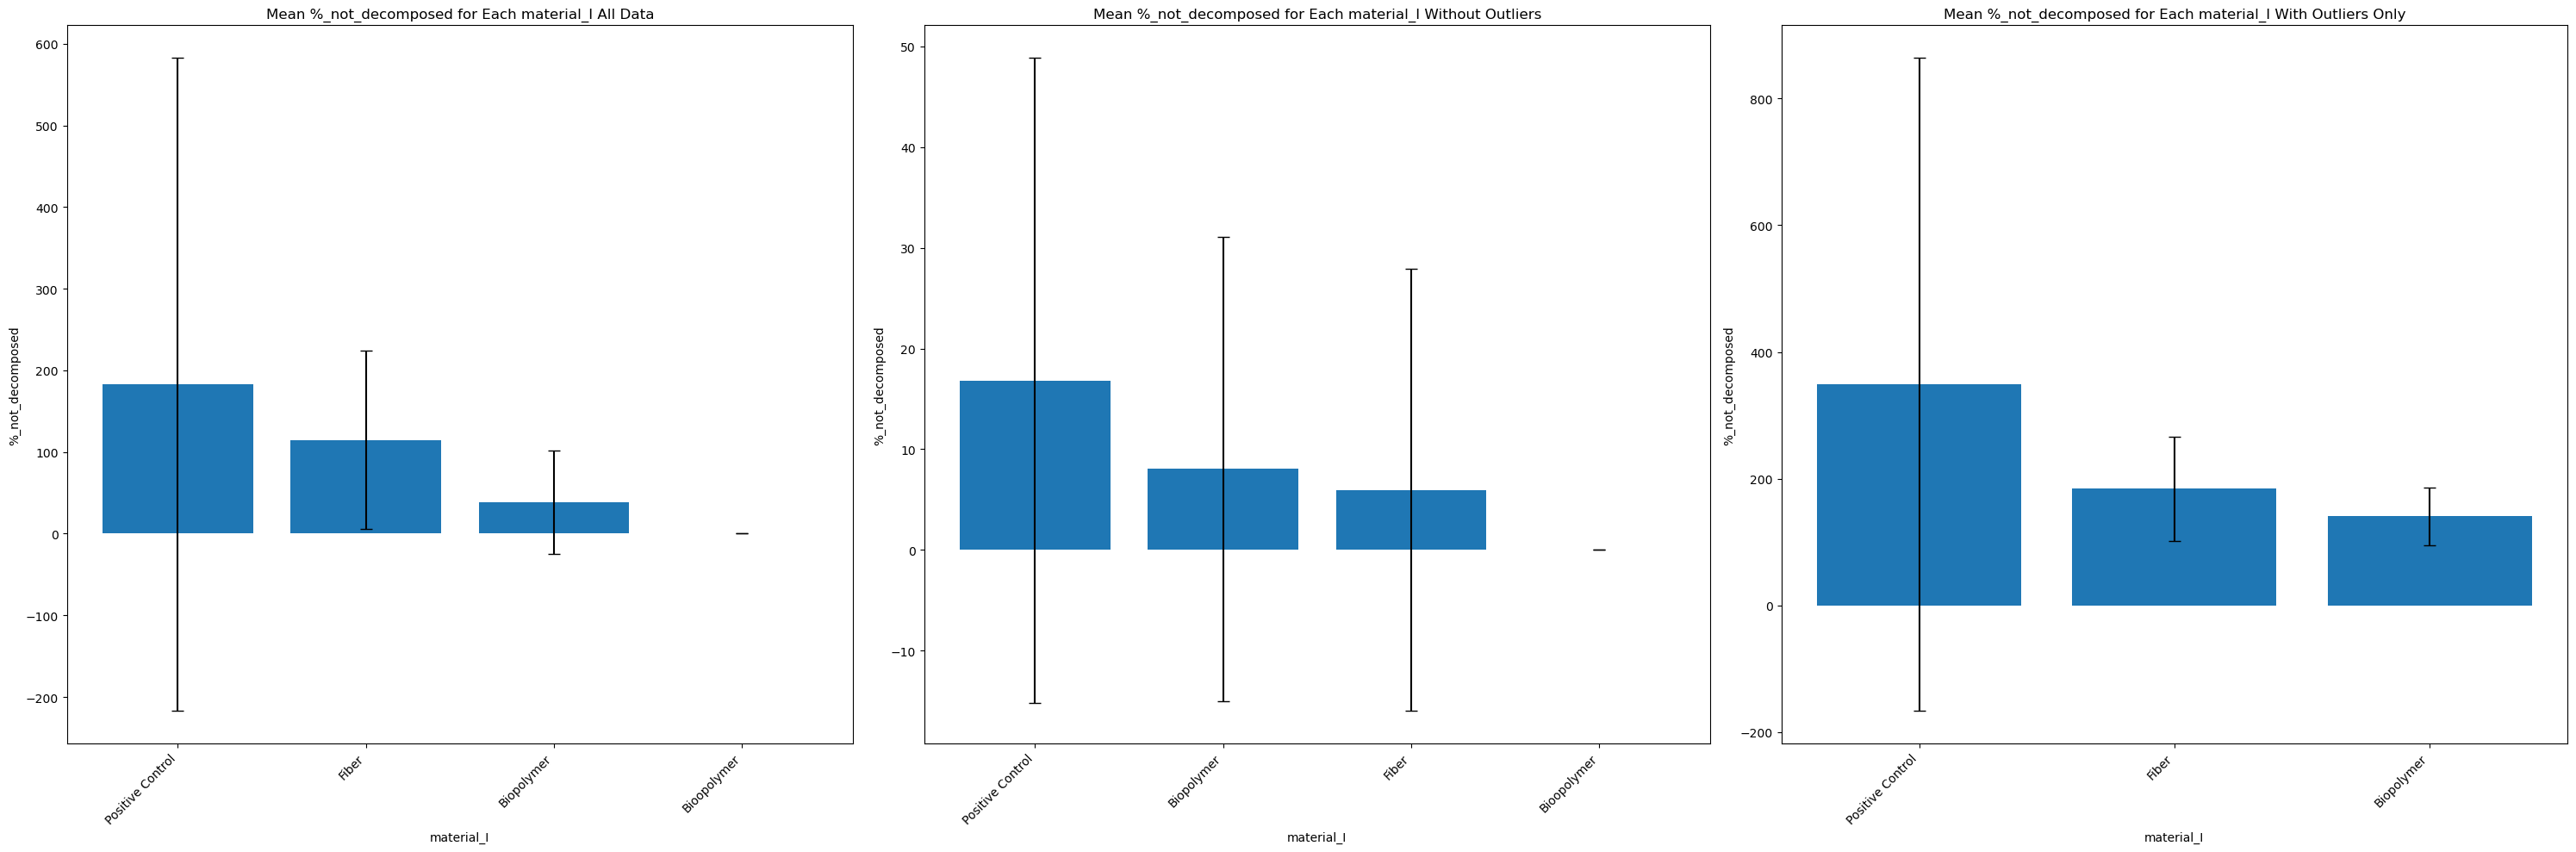

In [175]:
bar_whisker_combined_plot_horizontal(df_end, 'material_I', '%_not_decomposed')


/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')
/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')
/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')


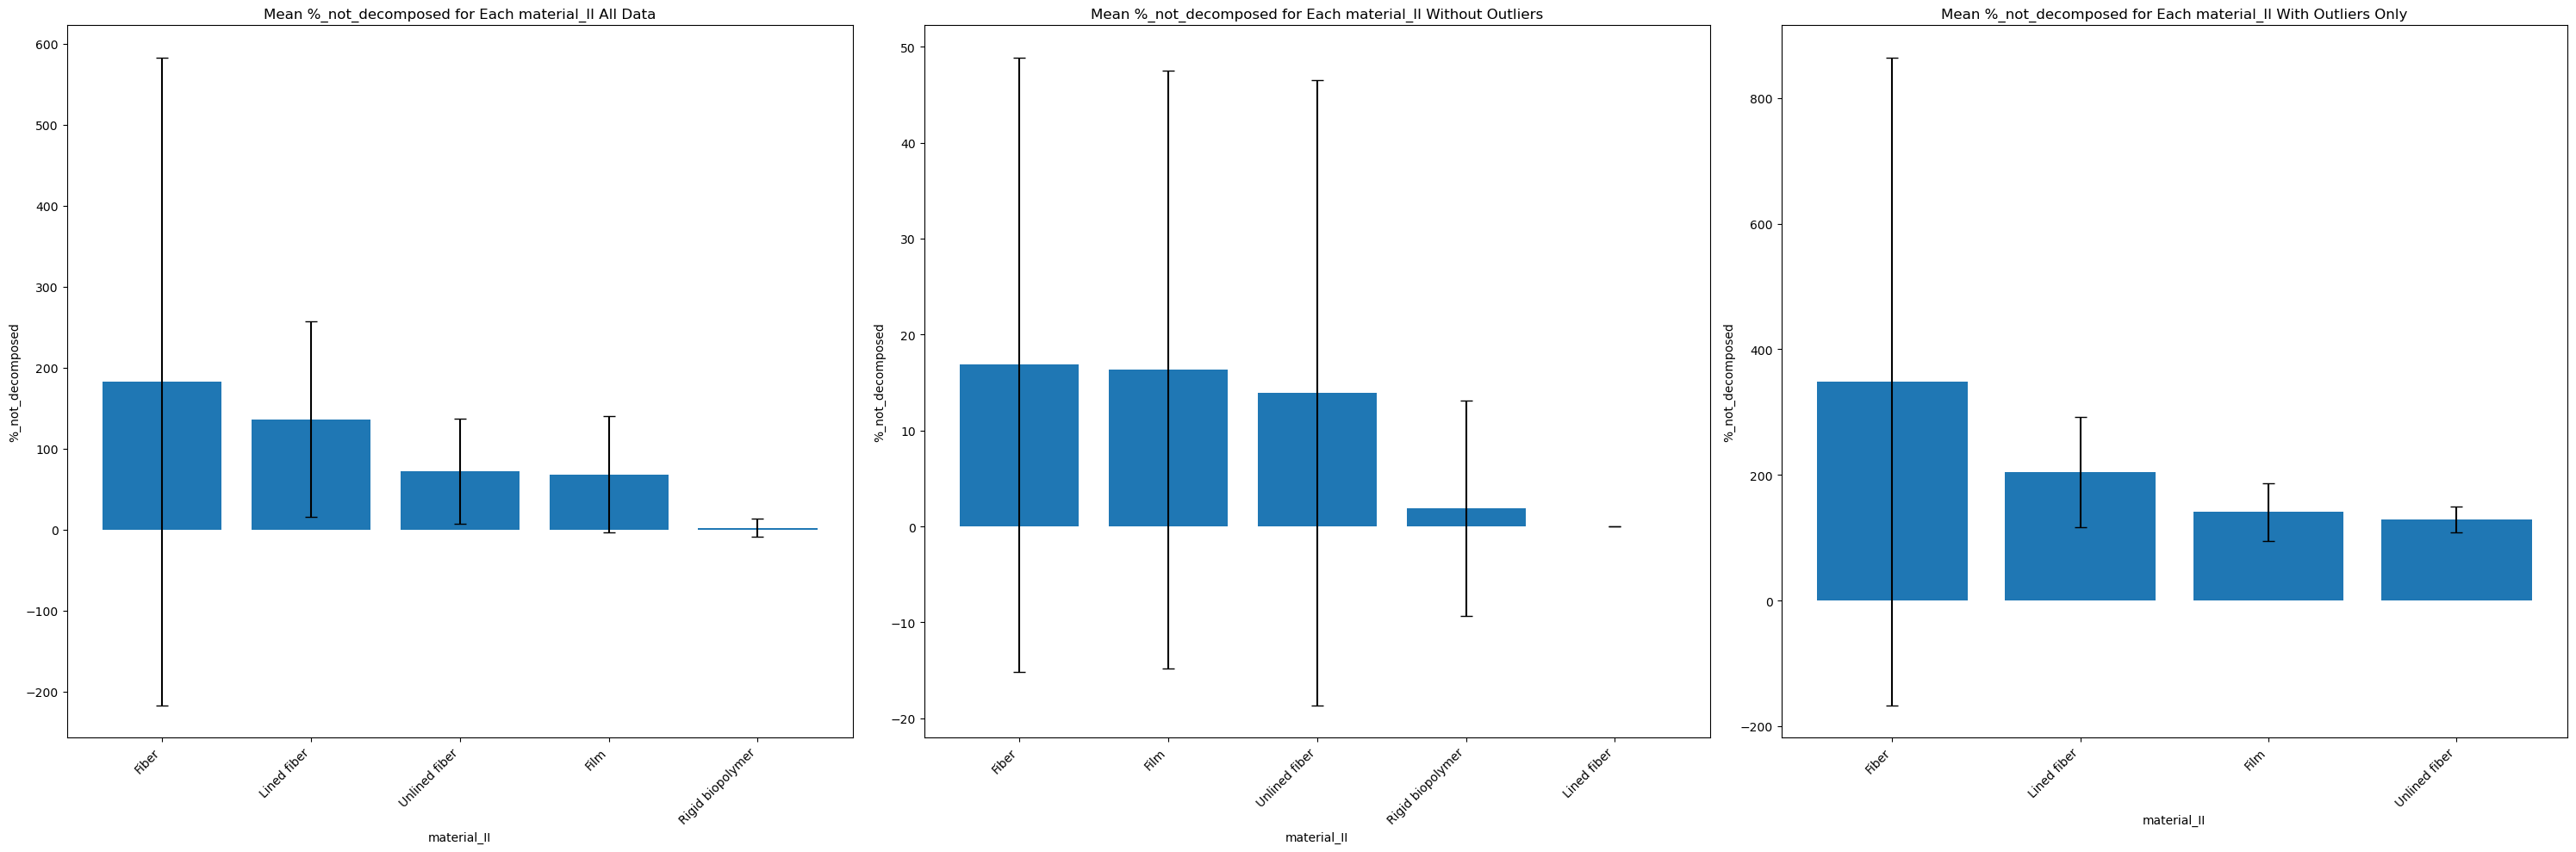

In [176]:
bar_whisker_combined_plot_horizontal(df_end, 'material_II', '%_not_decomposed')


/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')
/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')
/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')


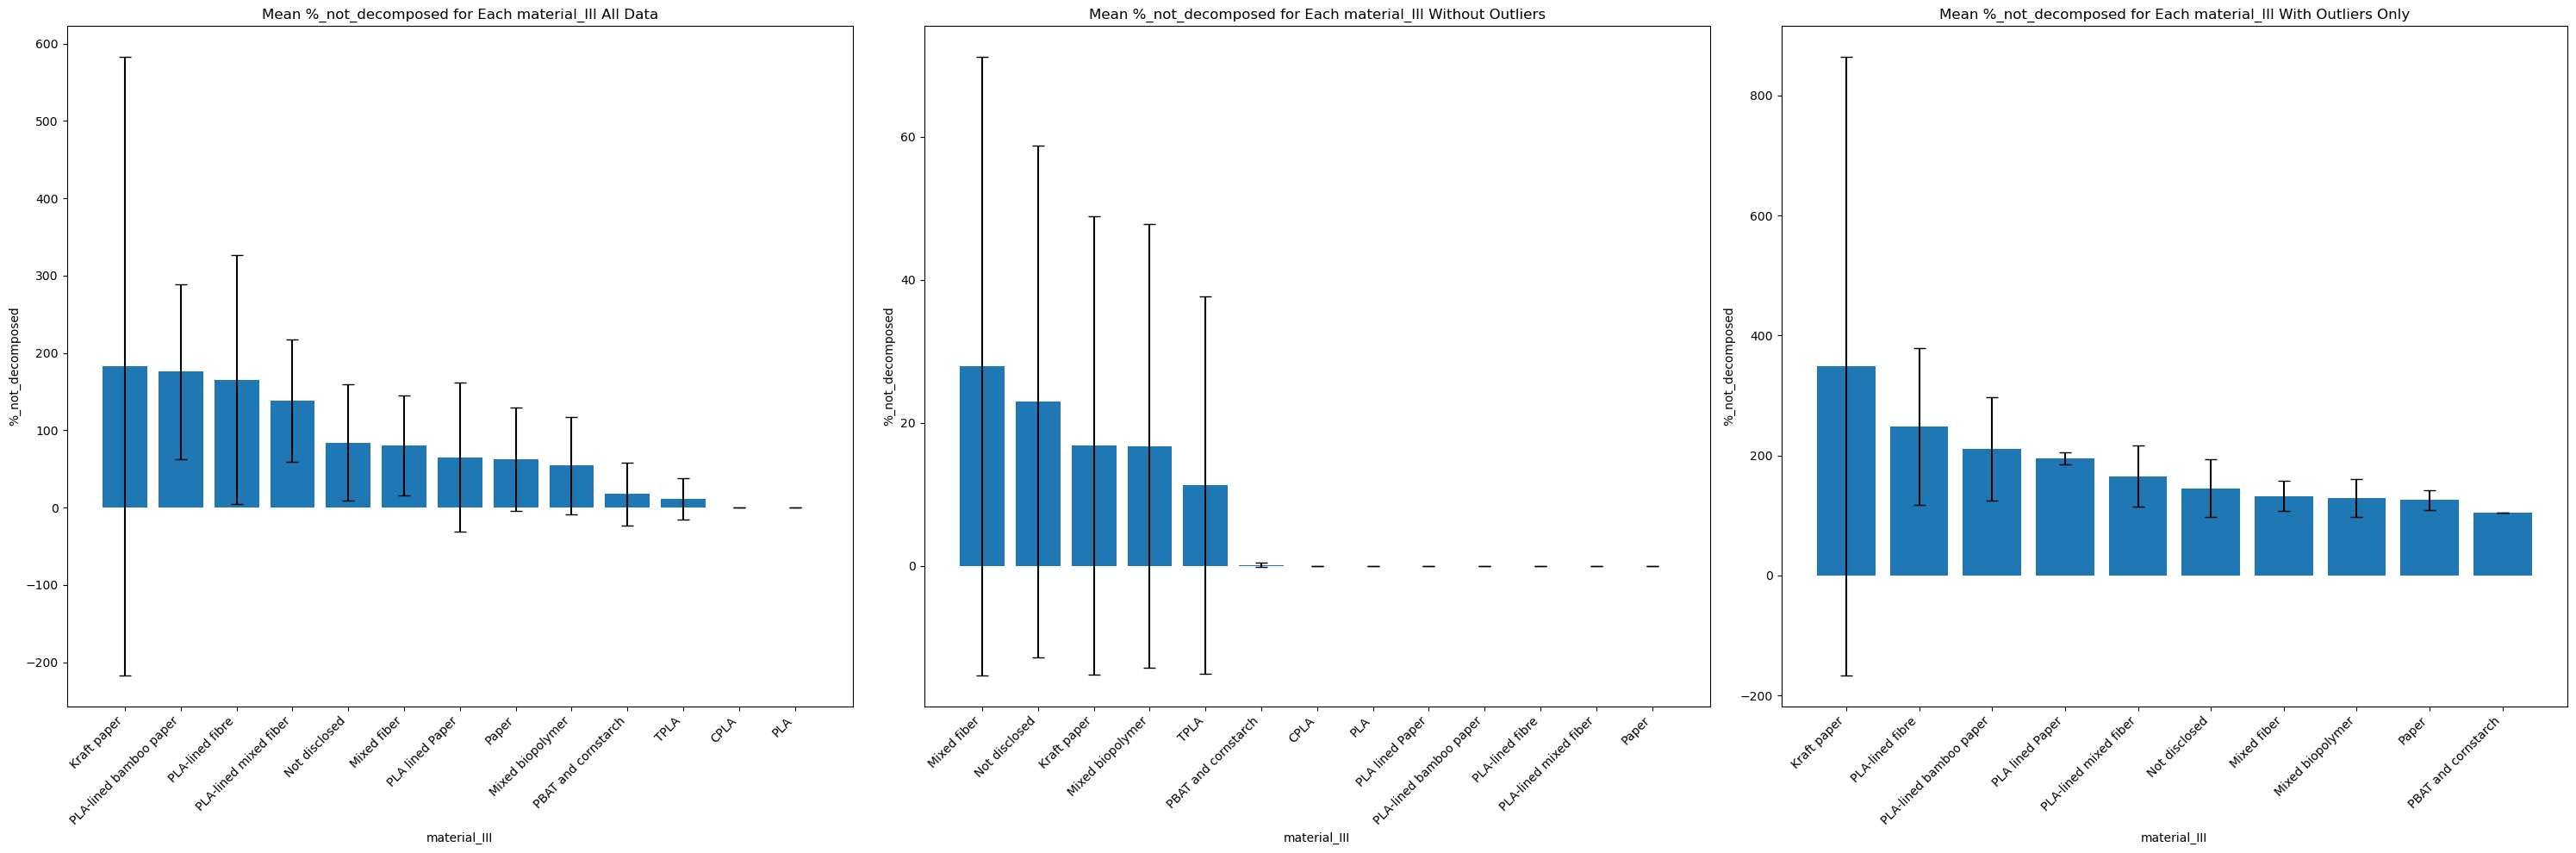

In [177]:
bar_whisker_combined_plot_horizontal(df_end, 'material_III', '%_not_decomposed')


/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')
/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')
/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')


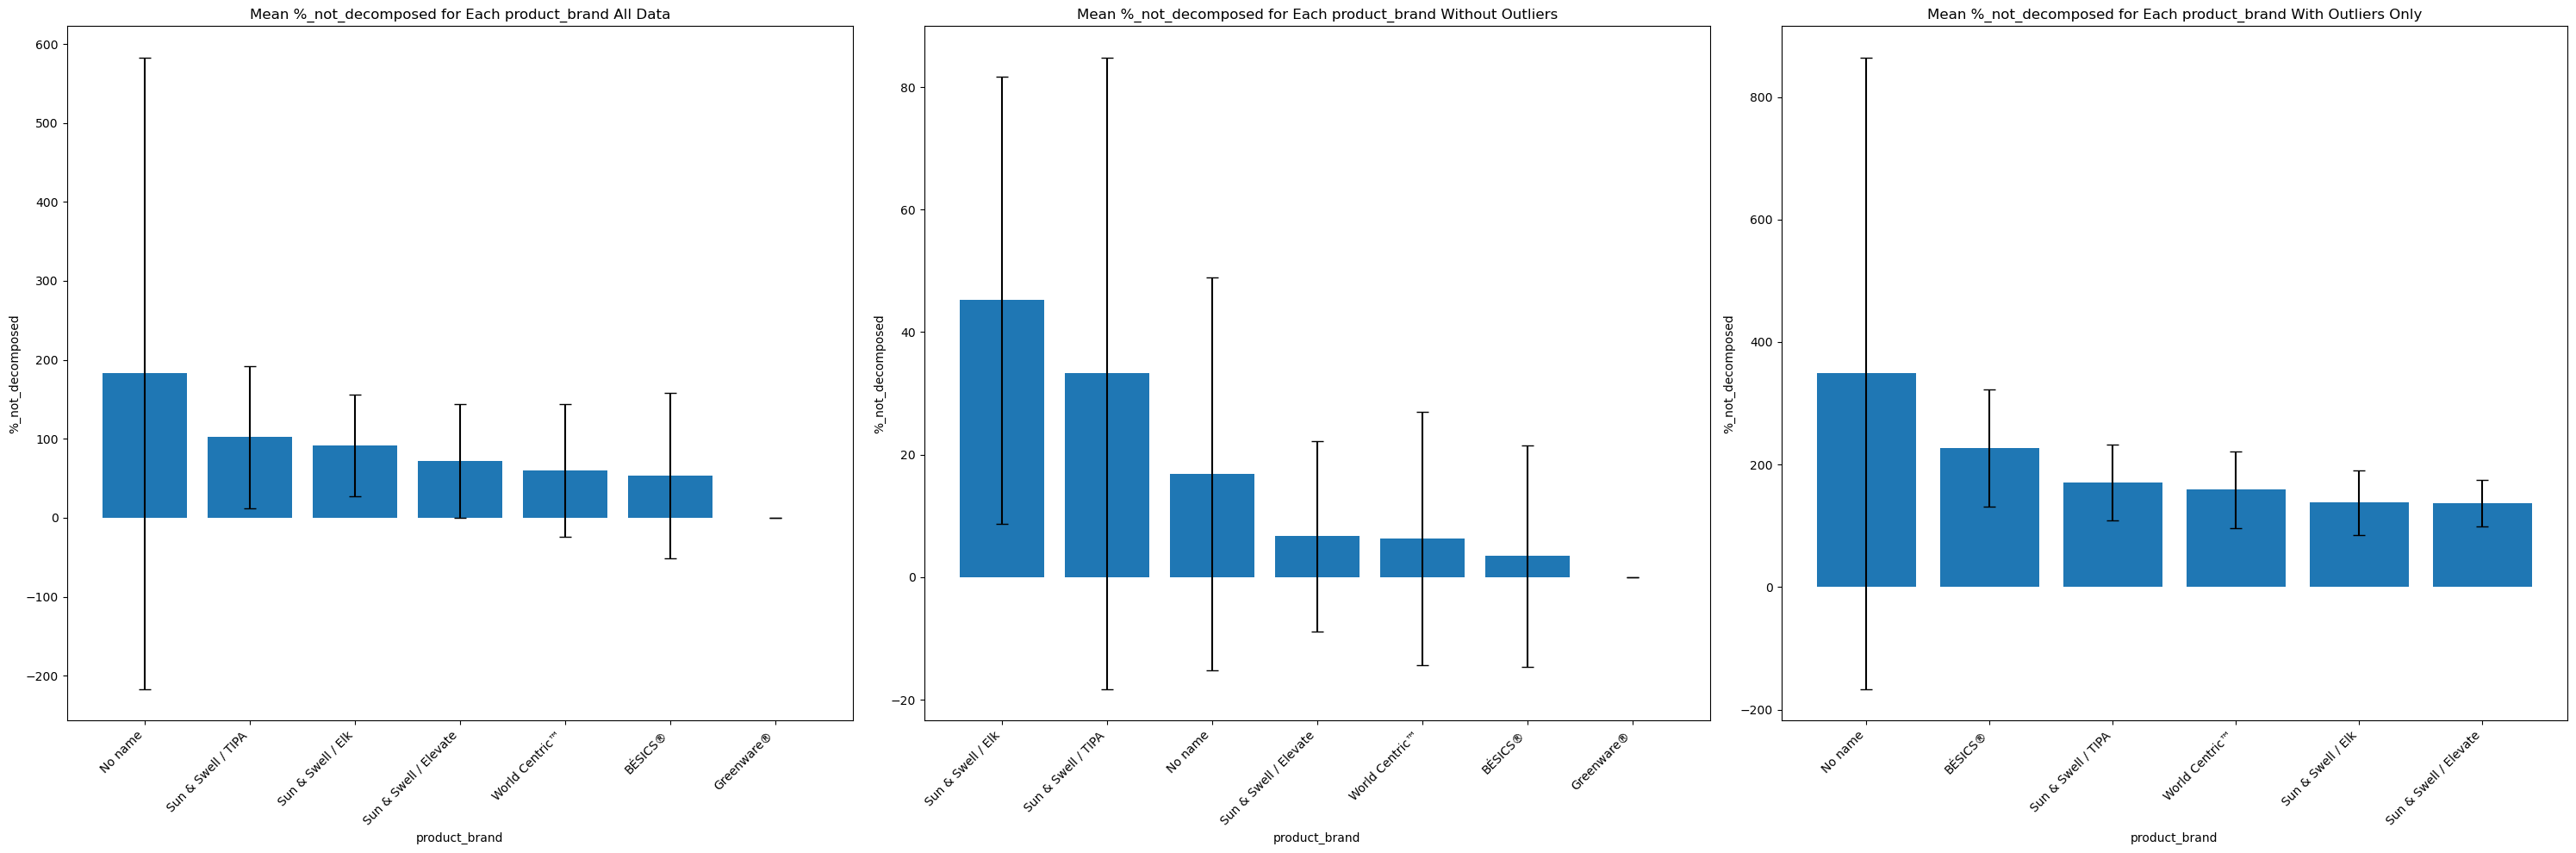

In [178]:
bar_whisker_combined_plot_horizontal(df_end, 'product_brand', '%_not_decomposed')

/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')
/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')
/var/folders/yz/szyqtrqj1q3g3zvv3tz4n0x00000gp/T/ipykernel_6741/3983512277.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')


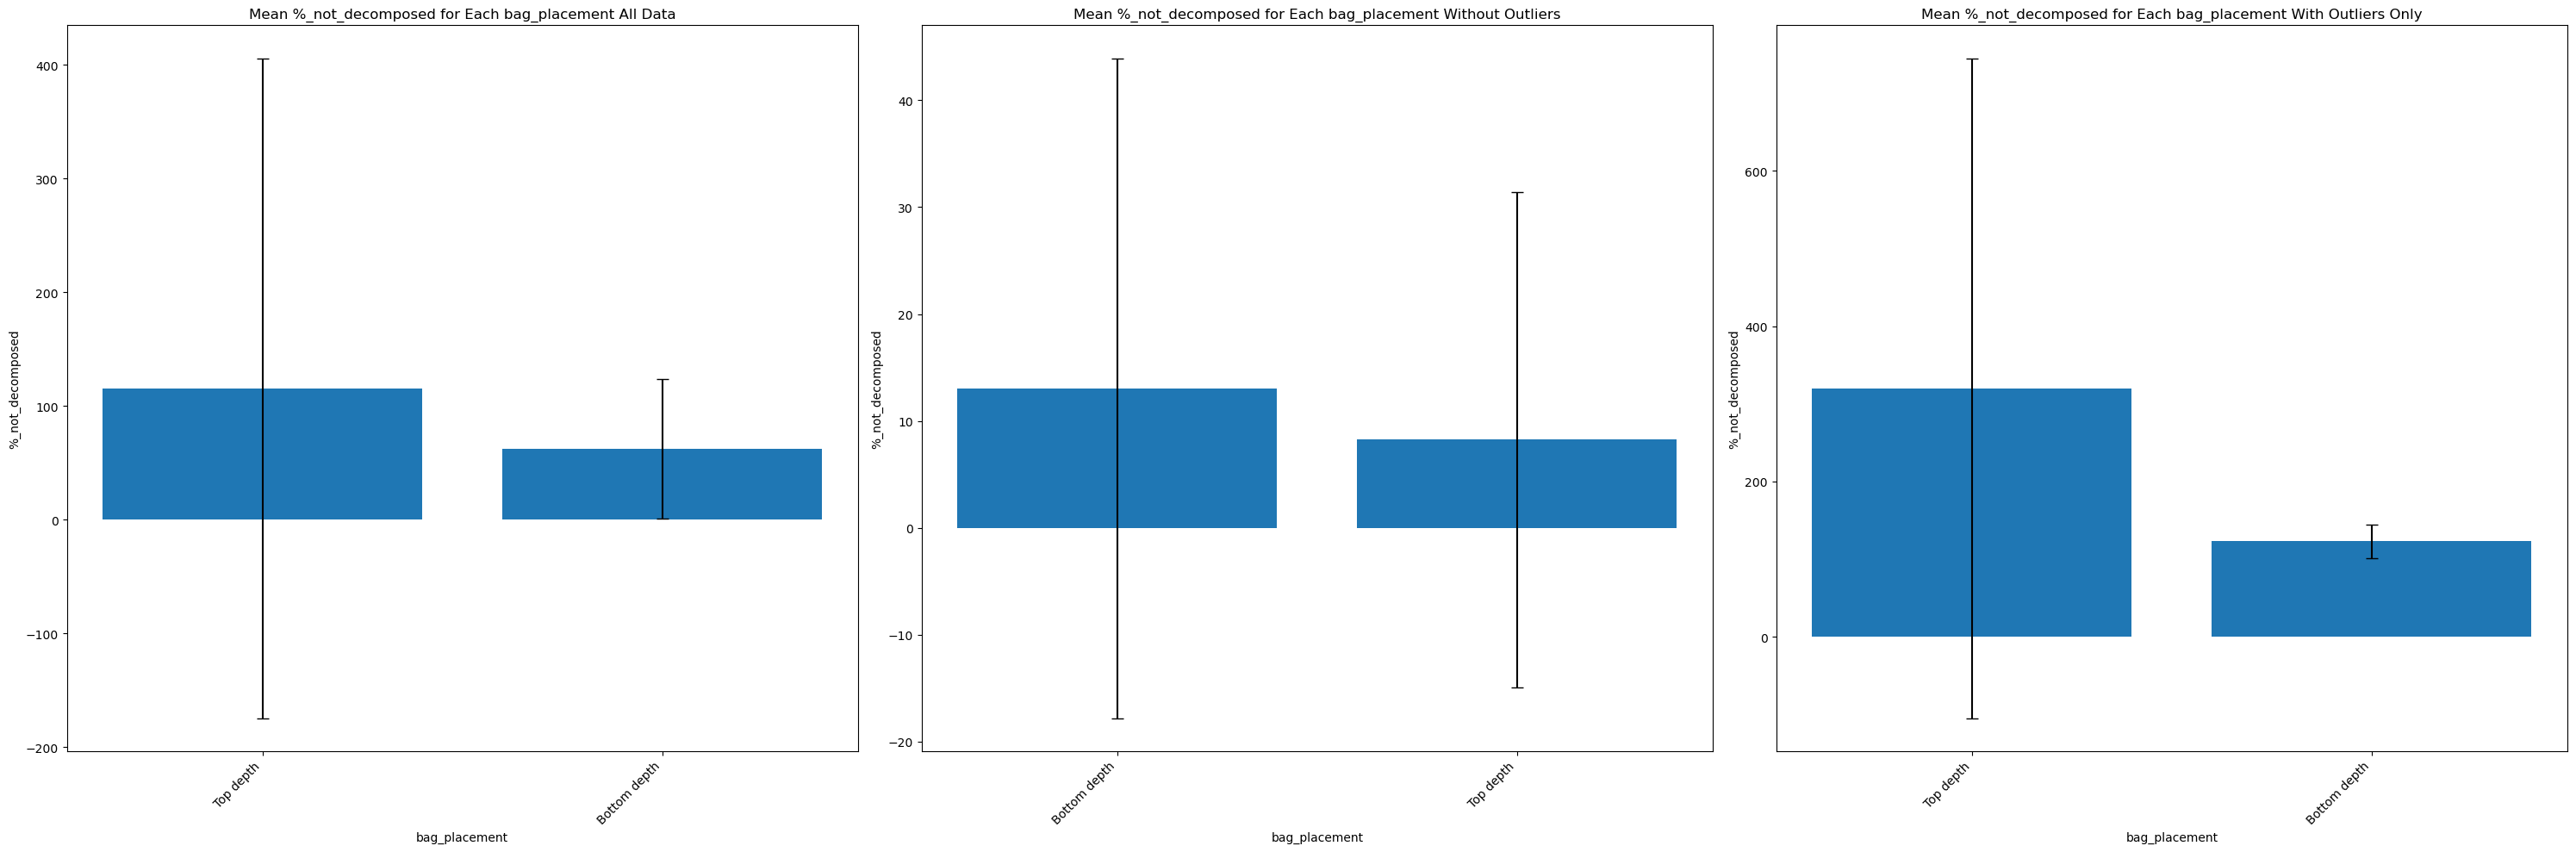

In [179]:
bar_whisker_combined_plot_horizontal(df_end, 'bag_placement', '%_not_decomposed')
